<a href="https://colab.research.google.com/github/eriksali/dds/blob/main/toy_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"\nOne can see that the contribution of  x0 decreases, and contribution of the noise increases. \nThis is completely in line with our intuition: \nin the beginning xt is made mainly of  x0 and in the end it's made mainly of noise.\n"

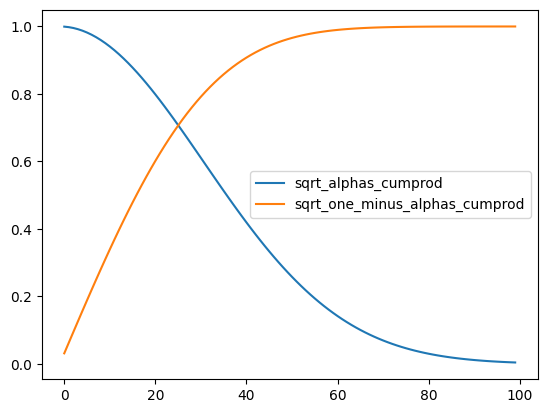

In [14]:
##https://www.kaggle.com/code/grishasizov/simple-denoising-diffusion-model-toy-1d-example
##https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=290edb0b

'''
Denoising diffusion probabilistic models, from the original paper Ho et al., 2020 to DALL-E and Stable Diffusion are becoming an increasingly successful at image generation.

The goal of this notebook to understand how they work by creating the simplest possible denoising diffusion model. Many existing training materials start with a relatively complex setting, e.g. generating an image. Here we are instead considering a toy model: the sample space is one-dimensional and the set of "realistic" samples consist of just one data point.

A lot of code here is based on this Huggingface colab notebook. We also refer to Ho et al., 2020 as "the paper" below
'''

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F



## Define initial setup

'''
The space of all possible samples is R
 - all real numbers. For comparison, in the original paper this was a space of all 256x256 images
The space of training samples consists of one element x0
. In the paper it consisted of all the images in the training set, e.g. CIFAR10
The model needs to generate realistic samples (the number x0
 in our case) from noise by iterative denoising

'''

## Let's define the hyperparameters:


x0 = -5  # "realistic" sample which the model needs to learn to generate
n_steps = 100  # number of denoising time steps


'''
define some functions of time which will be used below. First of all, we need to choose how the noise variance changes over time.
Following the beginning of section 4 of the paper, we choose variance  1−αt to change linearly from  0.001 to  0.2.
We'll also need cumulative product  α¯T=∏t=0Tαt and its square root
'''



alphas = 1. - torch.linspace(0.001, 0.2, n_steps)
alphas_cumprod = torch.cumprod(alphas, axis=0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - sqrt_alphas_cumprod ** 2)

'''
The equation between eqs. (8) an (9) in the paper states that  xt(x0,ϵ)=α¯t−−√x0+1−α¯t−−−−−√ϵ
 . This means the quantities above detemine how much starting point  x0
  and the noise  ϵ
  contribute into  xt
 . Let's plot them as functions of time
'''
##how much starting point x0 and the noise ϵ contribute into xt

plt.plot(sqrt_alphas_cumprod, label="sqrt_alphas_cumprod")
plt.plot(sqrt_one_minus_alphas_cumprod, label="sqrt_one_minus_alphas_cumprod")
plt.legend()

'''
One can see that the contribution of  x0 decreases, and contribution of the noise increases.
This is completely in line with our intuition:
in the beginning xt is made mainly of  x0 and in the end it's made mainly of noise.
'''




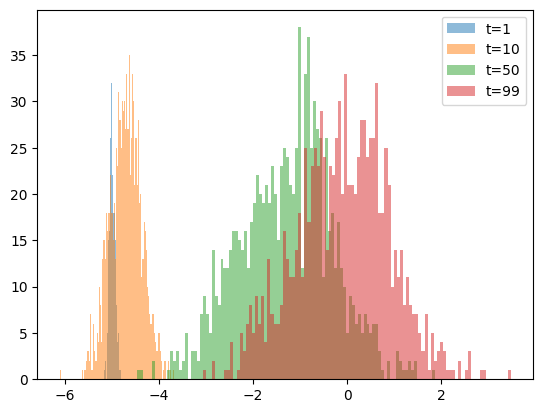

In [16]:
## Define forward diffusion step

## The following function allows us to sample  xt given  x0 and noise  ϵt
##  - see equation above eq. (9) in the paper

def q_sample(x_0, t, noise):
    """
    Sample x at time t given the value of x at t=0 and the noise
    """
    return sqrt_alphas_cumprod.gather(-1, t) * x_0 + sqrt_one_minus_alphas_cumprod.gather(-1, t) * noise


for t in [1, n_steps // 10, n_steps // 2, n_steps - 1]:
    noised_x = q_sample(x0, torch.tensor(t), torch.randn(1000))
    plt.hist(noised_x.numpy(), bins=100, alpha=0.5, label=f"t={t}");
plt.legend()


## Let's see how distribution of x evolves under the forward process - diffusion.
## Initially it's peaked at x0, later it becames wider and centers around 0






Text(0, 0.5, 'x')

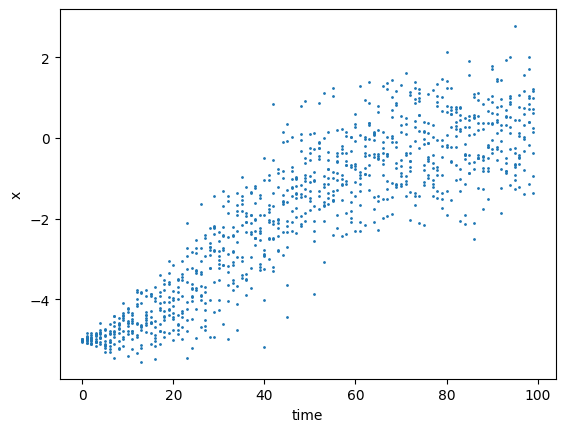

In [18]:
## Below the same process is shown as scatterplot
## - as we move forward in time (from left to right on the plot),
## diffusion makes the distribution wider and shift its mean to 0

res = [(t, q_sample(x0, torch.tensor(t), torch.randn(1)).item()) for _ in range(10) for t in range(n_steps)]
x, y = list(zip(*res))
plt.scatter(x, y, s=1)
plt.xlabel("time")
plt.ylabel("x")


In [20]:
## As section 3.2 of the paper describes, we need to train a model which can predict noise ϵt
## given xt and t. The paper uses a neural net (U-Net) for this purpose.
## In our, much simpler, setup the model can be linear:
## ϵt=axt+bt+c, where a, b, c are trainable parameters



class DenoiseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.a = torch.nn.Parameter(torch.tensor(1.))
        self.b = torch.nn.Parameter(torch.tensor(0.))
        self.c = torch.nn.Parameter(torch.tensor(0.))

    def forward(self, x, t):
        return self.a * x + self.b * t + self.c



## Below we run a simple PyTorch training loop:
## pick a random time step t, compute a loss at that time step (squared difference between actual and predicted noise),
## and adjust parameters a,b,c based on gradients of this loss.


def p_loss(x, t):
    # Generate a noise
    noise = torch.randn(t.shape)
    # Compute x at time t with this value of the noise - forward process
    noisy_x = q_sample(x, t, noise)
    # Use our trained model to predict the value of the noise, given x(t) and t
    noise_computed = denoise(noisy_x, t)
    # Compare predicted value of the noise with the actual value
    return F.mse_loss(noise, noise_computed)


## Below we run a simple PyTorch training loop:
## pick a random time step t, compute a loss at that time step (squared difference between actual and predicted noise),
## and adjust parameters a,b,c based on gradients of this loss.


denoise = DenoiseModel()
optimizer = torch.optim.Adam(denoise.parameters())

n_epochs = 10000
batch_size = 1000
for step in range(n_epochs):
    optimizer.zero_grad()
    t = torch.randint(0, n_steps, (batch_size, ))  # Pick random time step
    loss = p_loss(x0, t)
    loss.backward()
    if step % (n_epochs // 10) == 0:
        print(f"loss={loss.item():.4f}; a={denoise.a.item():.4f}, b={denoise.b.item():.4f}, c={denoise.c.item():.4f}")
    optimizer.step()
print(f"final: loss={loss.item():.4f}; a={denoise.a.item():.4f}, b={denoise.b.item():.4f}, c={denoise.c.item():.4f}")

loss=7.0470; a=1.0000, b=0.0000, c=0.0000
loss=0.9042; a=0.3553, b=-0.0053, c=0.6871
loss=0.7042; a=0.2847, b=-0.0108, c=0.9895
loss=0.5538; a=0.3455, b=-0.0146, c=1.3244
loss=0.5248; a=0.4284, b=-0.0216, c=1.7774
loss=0.4315; a=0.5255, b=-0.0277, c=2.3127
loss=0.3400; a=0.6275, b=-0.0347, c=2.8658
loss=0.3264; a=0.7173, b=-0.0413, c=3.3750
loss=0.3299; a=0.7900, b=-0.0466, c=3.7717
loss=0.3002; a=0.8342, b=-0.0491, c=4.0197
final: loss=0.2965; a=0.8547, b=-0.0500, c=4.1348


Text(0.5, 1.0, 'Reverse process - denoising')

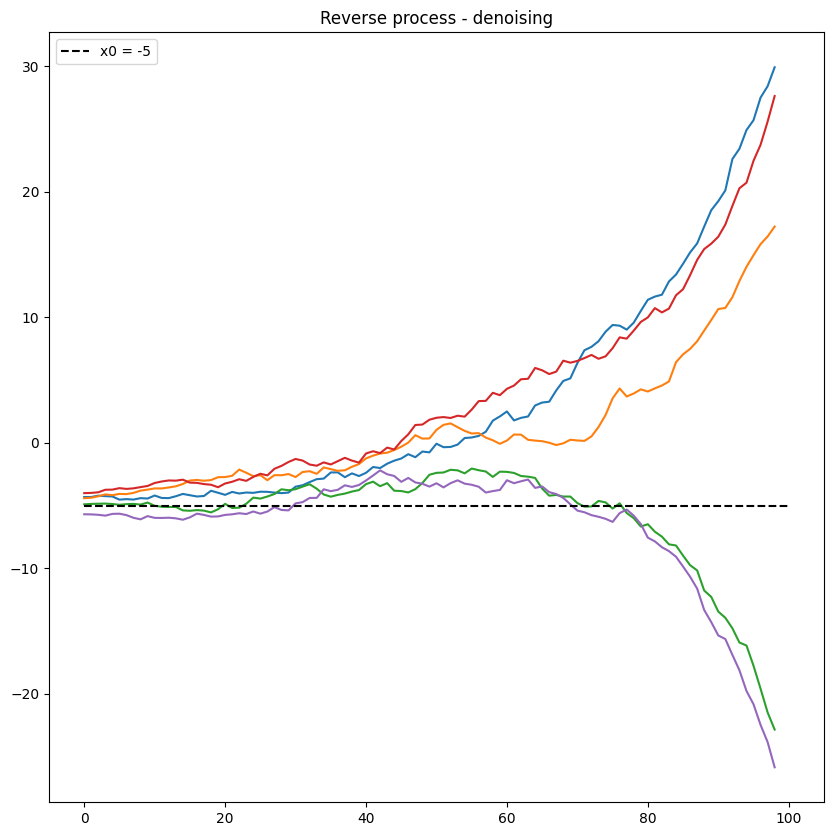

In [25]:

## Define reverse process step:

## Once the model is trained, we can use it to implement "backward process" (Algorith 2 from the paper). We'll go step by step from  t=99
## to t=0, at every step "denoising" xt to produce  xt−1. The function p_sample below performs one such step.
## Remeber that  xt−1 is distributed normally given xt
## - the function finds mean and variance of this distribution and then samples from it

## For posterior mean, see eq. (11) in the paper, also reused in Algorithm 2
## For posterior variance, see the beginning of section 3.2 in the paper (or eq. (7))


alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
posterior_variance = (1 - alphas) * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def p_sample(x, t):
    """
    One step of revese process sampling - Algorithm 2 from the paper
    """
    alpha_t = alphas.gather(-1, t)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod.gather(-1, t)
    # Get mean x[t - 1] conditioned at x[t] - see eq. (11) in the paper
    model_mean = torch.sqrt(1.0 / alpha_t) * (x - (1 - alpha_t) * denoise(x, t) / sqrt_one_minus_alphas_cumprod_t)
    # Get variance of x[t - 1]
    model_var = posterior_variance.gather(-1, t)
    # Samples for the normal distribution with given mean and variance
    return model_mean + torch.sqrt(model_var) * torch.randn(1)


## Below we apply reverse process for different random starting points x100.
## You could see that all of them converge to the vicinity of true  x0=−5


plt.figure(figsize=(10, 10))
for _ in range(5):
    x_gens = []
    x_gen = torch.randint(-50, 50, (1,))
    for i in range(n_steps - 1, 0, -1):
        x_gen = p_sample(x_gen, torch.tensor(i))
        x_gens.append(x_gen.detach().numpy()[0])
    plt.plot(x_gens[::-1])
plt.hlines(x0, 0, 100, color="black", linestyle="--", label=f"x0 = {x0}")
plt.legend(loc="upper left")
plt.title("Reverse process - denoising")




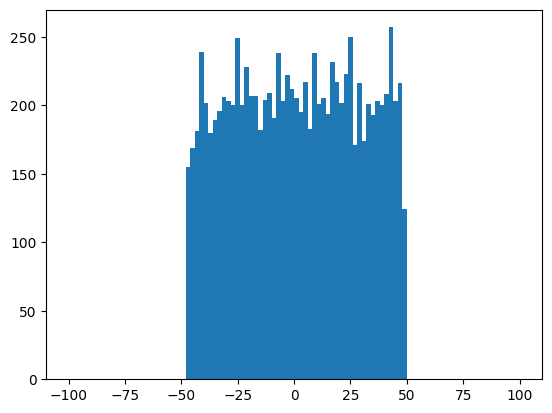

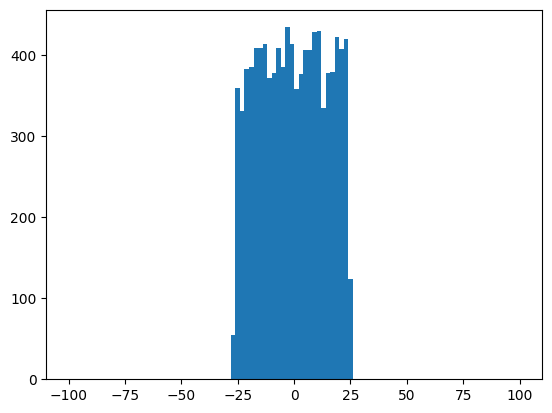

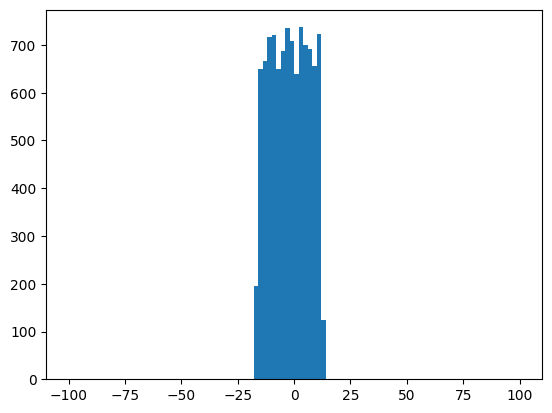

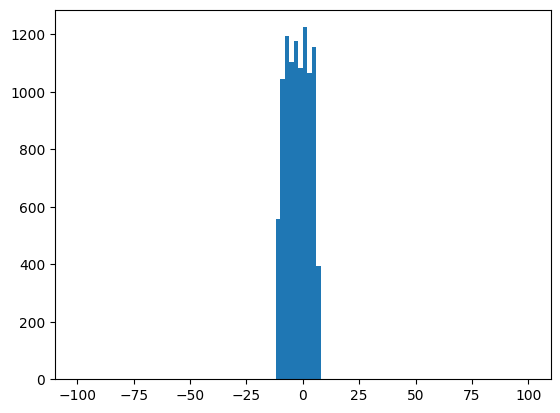

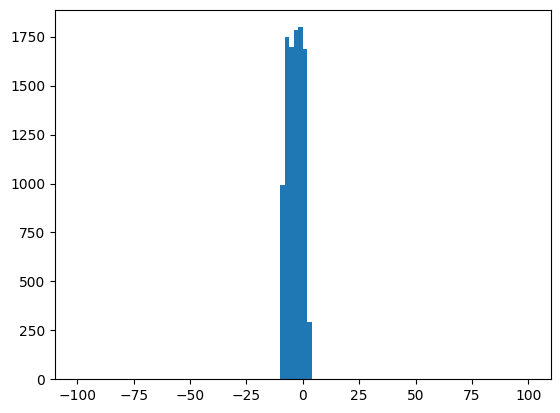

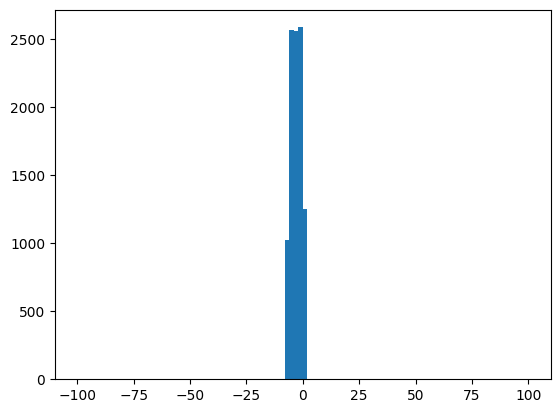

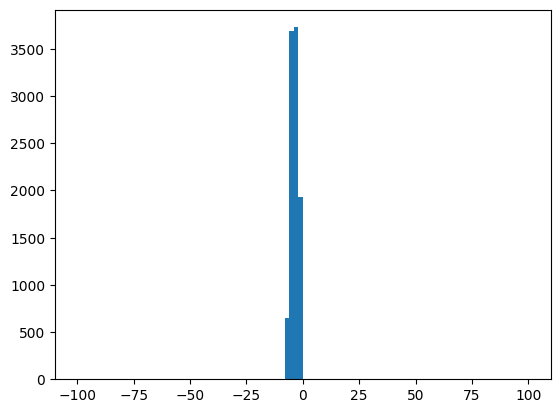

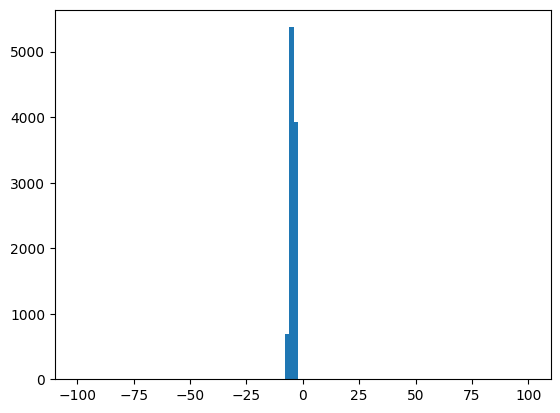

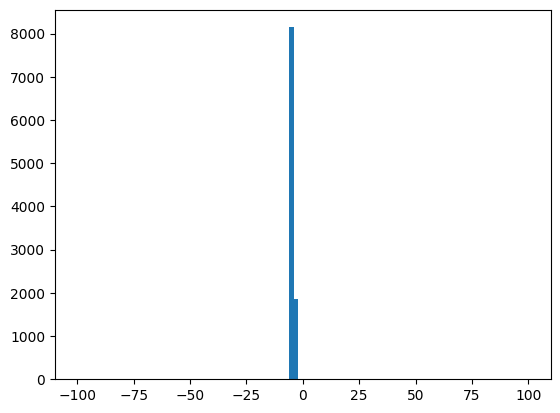

In [26]:
## Let's also see how the distribution of x evolves under the reverse "denoising" process

# Create a sample of 10000 "noisy" datapoint at time t = 100
x_gen = torch.randint(-100, 100, (10000,))
for i in range(n_steps - 1, 0, -1):
    # denoise the sample step by step backawards in time
    x_gen = p_sample(x_gen, torch.tensor(i))
    if i % 10 == 0:
        plt.hist(x_gen.detach().numpy(), range=(-100, 100), bins=100)
        plt.show()

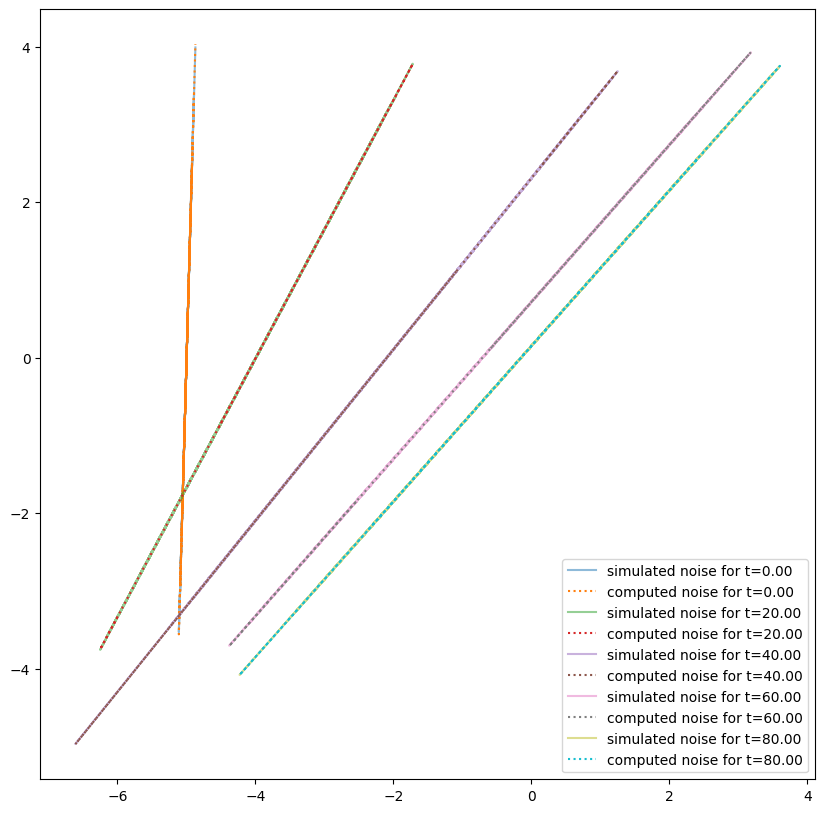

In [29]:
## Appendix

## Is the noise really linear?
## You could experiment with different values of x_0 and n_steps and notice that convergence gets better or worse depending on them.
## One of the reasons is that our model for predicting noise is really simple - it's linear in t and x.

## In this section we plot how the actual noise depends on t and x.
## It can be done in two ways: by simulation and by using an explit formula from the paper


## Simulate noise

from collections import defaultdict

x_scale = 4 # Range of x to plot
all_res = []
for t0 in range(n_steps): # Go over all time steps and over x in a certain range
    res = defaultdict(list)
    for x in np.linspace(-x_scale, x_scale, 10):
        noise_size = 1000

        # Generate noise and apply it to x to get "noisy" x
        noise = torch.randn((noise_size, 1))
        t = torch.tensor((t0,))
        noisy_x = q_sample(x0, t, noise)
        bin_size = 0.01

        # Group data by "noisy" x and compute average value of noise for a given "noisy" x
        noisy_quantised = ((noisy_x[:, 0] / bin_size).round() * bin_size).numpy()
        for i in range(noise_size):
            res[noisy_quantised[i]].append(noise[i, 0].item())

    averaged = {k: np.mean(res[k]) for k in res}
    x_noisy = list(averaged.keys())
    for k in averaged:
        all_res.append([t0, k, averaged[k]])


## Explicitly compute noise

## As stated in the paper,  xt(x0,ϵ)=α¯t−−√x0+1−α¯t−−−−−√ϵ. Expressing the noise ϵ
## from here we can compute noise given "noisy"  xt, initial value x0, and time t

def get_noise(x_noisy, x0, t):
    return (x_noisy - x0 * sqrt_alphas_cumprod[t]) / sqrt_one_minus_alphas_cumprod[t]

## Plot computed and simulated noise as a function of x, for a given t

## Plotting the noise as a function of x for different fixed values of t,
## one can see that dependence on x is linear.
## Of course, the simulated and computed values conicide.


plt.figure(figsize=(10, 10))
for t in range(0, n_steps, n_steps // 5):
    all_fixed_t = [val for val in all_res if val[0] == t]
    x_axis = [val[1] for val in all_fixed_t]
    plt.plot(x_axis, [val[2] for val in all_fixed_t], label=f"simulated noise for t={t:.2f}", linestyle="-", alpha=0.5)
    computed_noise = [get_noise(val[1], x0, t)  for val in all_fixed_t]
    plt.plot(x_axis, computed_noise, label=f"computed noise for t={t:.2f}", linestyle=":")
plt.legend(loc="lower right")



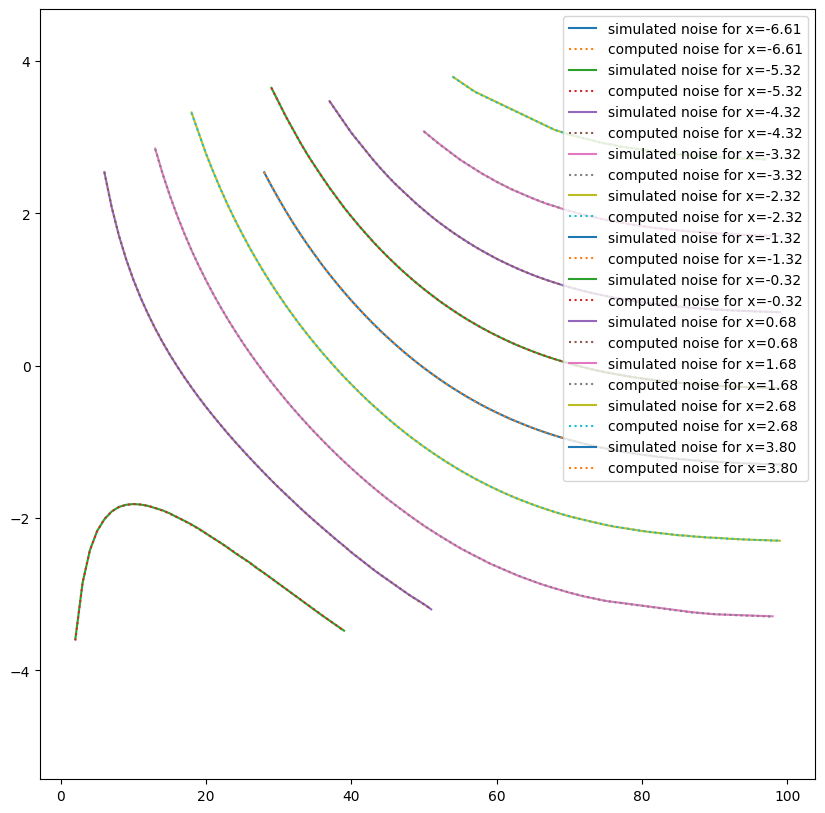

In [30]:
## Plot computed and simulated noise as a function of t, for a given x

## Dependence on t is non-linear in general,
## but can be approximated by a linear function for some x.


possible_noisy_x = sorted(set([val[1] for val in all_res]))
plt.figure(figsize=(10, 10))

for x_fixed in possible_noisy_x[::n_steps]:
    all_fixed_x = [x for x in all_res if np.abs(x[1] - x_fixed) < 1e-8]
    x_axis = [val[0] for val in all_fixed_x]
    plt.plot(x_axis, [val[2] for val in all_fixed_x], label=f"simulated noise for x={x_fixed:.2f}", linestyle="-")
    computed_noise = [get_noise(x_fixed, x0, val[0])  for val in all_fixed_x]
    plt.plot(x_axis, computed_noise, label=f"computed noise for x={x_fixed:.2f}", linestyle=":")
plt.legend(loc="upper right")



In [ ]:
import argparse
import traceback
import shutil
import logging
import yaml
import sys
import os
import torch
import numpy as np
import torch.utils.tensorboard as tb
import torch.distributed as dist
import torch.multiprocessing as mp

#from runners.diffusion import Diffusion
#from models.diffusion import Model
import math
import time
import datetime
from torchvision import transforms, datasets

#from core import Smooth
#from diffmodel import DiffusionModel

import torch.nn as nn
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
import torchvision.utils as tvu


import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms, datasets


IMAGENET_DATA_DIR = "stanford_cars/"


def show_images(data, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

##data = torchvision.datasets.StanfordCars(root=".", download=True)
##transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()])
data = datasets.ImageFolder(root=IMAGENET_DATA_DIR)

show_images(data)



import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)



from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]
    data_transform = transforms.Compose(data_transforms)

    train = datasets.ImageFolder(root=os.path.join(IMAGENET_DATA_DIR, 'cars_train'), transform=data_transform)
    test = datasets.ImageFolder(root=os.path.join(IMAGENET_DATA_DIR, 'cars_test'), transform=data_transform)

    return torch.utils.data.ConcatDataset([train, test])


from torchvision import transforms, datasets





def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)





####################################################################################################

from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model



def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()


######################################################################################################
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()









'''# Define data transformations (you can adjust these as needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Path to the root directory of the dataset
dataset_root = "standfor_car"

# Load the dataset
dataset = ImageFolder(root=dataset_root, transform=transform)

# Create a data loader
batch_size = 4
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Function to display images
def show_images(images):
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(1, batch_size, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy())
        plt.axis('off')
    plt.show()

# Display a batch of images
images, labels = next(iter(dataloader))
show_images(images)'''


In [ ]:
!pip install gradio openai

In [ ]:
import gradio as gr
demo = gr.load(
    "huggingface/facebook/wav2vec2-base-960h",
    title="Speech-to-text",
    inputs="mic",
    outputs=["text", "file"],
    output_label=["Transcribed Text", "Save Output As"],
    description="Let me try to guess what you're saying!"
)
demo.launch()


Fetching model from: https://huggingface.co/facebook/wav2vec2-base-960h


/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:43: UserWarning: You have unused kwarg parameters in Interface, please remove them: {'output_label': ['Transcribed Text', 'Save Output As']}
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:

imUsingColab = True

if imUsingColab:
    !pip install gensim
    !pip install pyLDAvis
    !pip install vega
    !pip install altair


import re
import spacy

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

# import numpy for matrix operation
import numpy as np


from pprint import pprint
import pandas as pd

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

## from google.colab import drive
## drive.mount('/content/drive/')

##!unzip -uq "/content/Names_207039.zip" -d "/content/"
## !unzip -uq "/content/test_names_220610" -d "/content/"
!unzip -uq "/content/mallet-2.0.8.zip" -d "/content/"
## !unzip -uq "/content/reviews_words.zip" -d "/content/"
!unzip -uq "/content/test_name.zip" -d "/content/"

##dirpath = '/content/Names_207039/'
## dirpath = '/content/test_names/
## dirpath = '/content/reviews_words/'
dirpath = '/content/test_name/'
mallet_path = '/content/mallet-2.0.8/bin/mallet'


import os
## Setup mallet environment change it according to your drive
os.environ.update({'MALLET_HOME':r'/content/mallet-2.0.8'})

## Setup mallet path change it according to your drive

files = [os.path.join(dirpath, fname) for fname in os.listdir(dirpath)]
corpus_text = []

for filename in sorted(files):
    with open(filename, 'r') as f:
        corpus_text += [f.read()]




from pathlib import Path

doc_names = [Path(file).stem for file in sorted(files)]

# Apply Preprocessing on the Corpus

# Apply Preprocessing on the Corpus

import nltk

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

# stop loss words
stop = set(stopwords.words('english')
)


# punctuation
exclude = set(string.punctuation)

# lemmatization
lemma = WordNetLemmatizer()

# One function for all the steps:
def clean(doc):

    doc = re.sub("([^\x00-\x7F])+"," ", str(doc))
    ## doc = re.sub(r'\b\d+(?:\.\d+)?\s+', '', str(doc))
    ## print(doc)
    # convert text into lower case + split into words
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])

    for z in stop_free:

      ## string = 'abcd1234efg567'
      z = re.sub(r'\b\d+(?:\.\d+)?\s+', '', str(z))

      newstring = ''.join([i for i in z if not i.isdigit()]).lower()
      if not(len(newstring) < 2):
          ## print(newstring)
          stringVal = stringVal + " " + newstring

    # remove any stop words present
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)

    # remove punctuations + normalize the text
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split() if not word.isdigit())
    return normalized

# clean data stored in a new list
clean_corpus    = [clean(doc).split() for doc in corpus_text]
## data_lemmatized = [clean(doc).split() for doc in corpus]

# Create Dictionary
##id2word = corpora.Dictionary(data_lemmatized)
id2word = corpora.Dictionary(clean_corpus)


# Create Corpus
texts = clean_corpus

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Human readable format of corpus (term-frequency)
## [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]]

'''
4. Build the Bigram, Trigram Models and Lemmatize
Let’s form the bigram and trigrams using the Phrases model. This is passed to Phraser() for efficiency in speed of execution.
Next, lemmatize each word to its root form, keeping only nouns, adjectives, verbs and adverbs.
We keep only these POS tags because they are the ones contributing the most to the meaning of the sentences.
Here, we use spacy for lemmatization.
'''


from nltk.corpus import stopwords
stop_words = stopwords.words('english')
## stop_words.extend(['for', 'and', 'to', 'the', 'you', 'not', 'from', 'subject', 're', 'edu', 'use'])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(texts, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[texts], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    ## nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

data_ready = process_words(texts)  # processed Text Data!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 15.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=b5bf59cf5d726966bfbb2d2acad8484d86781779487acb225abbfc65a77072a9
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=2fbe06acea64d75f2ca89a455efffb8b25b1e34228d2cb8acdaff91cbbb01720
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn
Looking in 

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping
/usr/local/lib/python3.8/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package

In [ ]:
# To build the LDA topic model using LdaModel(), we need the corpus and the dictionary.

# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
'''
lda_model = gensim.models.wrappers.LdaMallet(mallet_path,
                                          corpus=corpus,
                                          num_topics=4,
                                          ## alpha=1/num_topics,
                                          alpha=50/4,
                                          id2word=id2word,
                                          workers=40,
                                          optimize_interval=4,
                                          iterations=500)
                                          ##iterations=1500)


'''

optimal_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)




Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

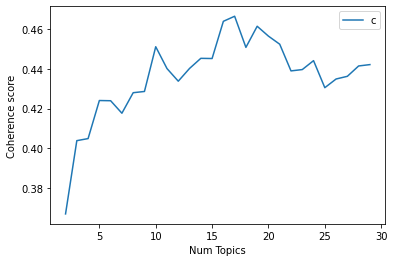

Num Topics = 2  has Coherence Value of 0.367
Num Topics = 3  has Coherence Value of 0.4038
Num Topics = 4  has Coherence Value of 0.4049
Num Topics = 5  has Coherence Value of 0.424
Num Topics = 6  has Coherence Value of 0.4239
Num Topics = 7  has Coherence Value of 0.4176
Num Topics = 8  has Coherence Value of 0.428
Num Topics = 9  has Coherence Value of 0.4286
Num Topics = 10  has Coherence Value of 0.4511
Num Topics = 11  has Coherence Value of 0.4401
Num Topics = 12  has Coherence Value of 0.4338
Num Topics = 13  has Coherence Value of 0.4402
Num Topics = 14  has Coherence Value of 0.4452
Num Topics = 15  has Coherence Value of 0.4451
Num Topics = 16  has Coherence Value of 0.4639
Num Topics = 17  has Coherence Value of 0.4664
Num Topics = 18  has Coherence Value of 0.4508
Num Topics = 19  has Coherence Value of 0.4614
Num Topics = 20  has Coherence Value of 0.4564
Num Topics = 21  has Coherence Value of 0.4523
Num Topics = 22  has Coherence Value of 0.4389
Num Topics = 23  has Coh

In [ ]:
# To build the LDA topic model using LdaModel(), we need the corpus and the dictionary.

# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
'''
lda_model = gensim.models.wrappers.LdaMallet(mallet_path,
                                          corpus=corpus,
                                          num_topics=4,
                                          ## alpha=1/num_topics,
                                          alpha=50/4,
                                          id2word=id2word,
                                          workers=40,
                                          optimize_interval=4,
                                          iterations=500)
                                          ##iterations=1500)




lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)


pprint(lda_model.print_topics())
'''

'''
# Converting list of documents (corpus) into Document Term Matrix using the dictionary
doc_term_matrix = [id2word.doc2bow(i) for i in clean_corpus]
doc_term_matrix


nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
## stop_words.extend(['for', 'and', 'to', 'the', 'you', 'not', 'from', 'subject', 're', 'edu', 'use'])

from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize


def flattern(doc):

    # split into words
    split_into_words = " ".join([i for i in doc.split() if not i.isdigit()])
    ## split_into_words = " ".join([i for i in doc.split()])

    return split_into_words

# Saving data in a new list
texts = [flattern(doc).split() for doc in corpus_text]

##
##def remove_stopwords(texts):
  ##for text in texts:
    ##return [word for word in simple_preprocess(str(text)) if word not in stop_words]
##

## text = "Nick likes to play football, however he is not too fond of tennis."
for text in texts:
  text_tokens = word_tokenize(str(text))
  text = [word for word in text_tokens if not word in stop_words]
  ## text = [word for word in text_tokens if not word in stopwords.words()]

  ## print(text)

##for doc in corpus_text:
## texts = remove_stopwords(texts)
## corpus = remove_stopwords(list(texts))

# Create Dictionary
id2word = corpora.Dictionary(texts)
## id2word.filter_extremes(no_below=15, no_above=0.4, keep_n=80000)

# Term Document Frequency
# https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html

corpus = [id2word.doc2bow(text) for text in texts]

##corpus = [TaggedDocument(simple_preprocess(text), [i])
                  ##for i, text in enumerate(texts)]

#### apply(lambda x: gensim.parsing.preprocessing.remove_stopwords(" ".join(x)))

'''


def compute_coherence_values(dictionary, corpus, texts, limit, start, step):

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):



        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10000,
                                           passes=2,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
        '''
        lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           ## update_every=1,
                                           chunksize=1000,
                                           passes=5,
                                           alpha=50/num_topics,
                                           eta=0.2,
                                           per_word_topics=True)

        '''
        '''
        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                                 corpus=corpus,
                                                 num_topics=num_topics,
                                                 ## alpha=1/num_topics,
                                                 alpha=50/num_topics,
                                                 id2word=id2word,
                                                 workers=40,
                                                 optimize_interval=4,
                                                 iterations=500)
                                                 ##iterations=1500)

        lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
        '''

        model_list.append(lda_model)

        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        ## coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit=31, step=1)



import csv

with open('/content/lda_cv.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    header = ['K', 'CV']
    writer.writerow(header)

    limit=31; start=2; step=1;

    x = range(start, limit, step)
    # Show graph

    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()


    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
        data = [m, round(cv, 4)]
        writer.writerow(data)

In [ ]:
# To build the LDA topic model using LdaModel(), we need the corpus and the dictionary.

# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
'''
lda_model = gensim.models.wrappers.LdaMallet(mallet_path,
                                          corpus=corpus,
                                          num_topics=4,
                                          ## alpha=1/num_topics,
                                          alpha=50/4,
                                          id2word=id2word,
                                          workers=40,
                                          optimize_interval=4,
                                          iterations=500)
                                          ##iterations=1500)



'''

optimal_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)


In [ ]:
# To build the LDA topic model using LdaModel(), we need the corpus and the dictionary.

# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
'''
lda_model = gensim.models.wrappers.LdaMallet(mallet_path,
                                          corpus=corpus,
                                          num_topics=4,
                                          ## alpha=1/num_topics,
                                          alpha=50/4,
                                          id2word=id2word,
                                          workers=40,
                                          optimize_interval=4,
                                          iterations=500)
                                          ##iterations=1500)




lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)


pprint(lda_model.print_topics())
'''

'''
# Converting list of documents (corpus) into Document Term Matrix using the dictionary
doc_term_matrix = [id2word.doc2bow(i) for i in clean_corpus]
doc_term_matrix


nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
## stop_words.extend(['for', 'and', 'to', 'the', 'you', 'not', 'from', 'subject', 're', 'edu', 'use'])

from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize


def flattern(doc):

    # split into words
    split_into_words = " ".join([i for i in doc.split() if not i.isdigit()])
    ## split_into_words = " ".join([i for i in doc.split()])

    return split_into_words

# Saving data in a new list
texts = [flattern(doc).split() for doc in corpus_text]

##
##def remove_stopwords(texts):
  ##for text in texts:
    ##return [word for word in simple_preprocess(str(text)) if word not in stop_words]
##

## text = "Nick likes to play football, however he is not too fond of tennis."
for text in texts:
  text_tokens = word_tokenize(str(text))
  text = [word for word in text_tokens if not word in stop_words]
  ## text = [word for word in text_tokens if not word in stopwords.words()]

  ## print(text)

##for doc in corpus_text:
## texts = remove_stopwords(texts)
## corpus = remove_stopwords(list(texts))

# Create Dictionary
id2word = corpora.Dictionary(texts)
## id2word.filter_extremes(no_below=15, no_above=0.4, keep_n=80000)

# Term Document Frequency
# https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html

corpus = [id2word.doc2bow(text) for text in texts]

##corpus = [TaggedDocument(simple_preprocess(text), [i])
                  ##for i, text in enumerate(texts)]

#### apply(lambda x: gensim.parsing.preprocessing.remove_stopwords(" ".join(x)))

'''


def compute_coherence_values(dictionary, corpus, texts, limit, start, step):

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):


        lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           ## update_every=1,
                                           chunksize=1000,
                                           passes=5,
                                           alpha=50/num_topics,
                                           eta=0.2,
                                           per_word_topics=True)


        '''
        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                                 corpus=corpus,
                                                 num_topics=num_topics,
                                                 ## alpha=1/num_topics,
                                                 alpha=50/num_topics,
                                                 id2word=id2word,
                                                 workers=40,
                                                 optimize_interval=4,
                                                 iterations=500)
                                                 ##iterations=1500)

        lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
        '''

        model_list.append(lda_model)

        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        ## coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit=30, step=1)



import csv

with open('/content/lda_cv.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    header = ['K', 'CV']
    writer.writerow(header)

    limit=30; start=2; step=1;

    x = range(start, limit, step)
    # Show graph

    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()


    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
        data = [m, round(cv, 4)]
        writer.writerow(data)

In [ ]:
optimal_model = model_list[19]
print(coherence_values[19])

0.45234235762224834


In [ ]:

'''
6. What is the Dominant topic and its percentage contribution in each document

In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant.
The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.
This way, you will know which document belongs predominantly to which topic.
'''

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_ready):

    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.
Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)

            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    names = pd.Series(doc_names)

    sent_topics_df = pd.concat([sent_topics_df, contents, names], axis=1)
    ## sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(
ldamodel=optimal_model, corpus=corpus, texts=data_ready)


# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()

df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Name']



In [ ]:
'''
7. The most representative sentence for each topic
Sometimes you want to get samples of sentences that most represent a given topic. This code gets the most exemplar sentence for each topic.
'''

# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text", "Title"]

# Show
sent_topics_sorteddf_mallet.head(20)


Topic_Num  Topic_Perc_Contrib  \
0         0.0              0.8100   
1         1.0              0.8951   
2         2.0              0.7201   
3         3.0              0.8327   
4         4.0              0.7958   
5         5.0              0.7418   
6         6.0              0.7625   
7         7.0              0.8171   
8         8.0              0.8643   
9         9.0              0.6841   
10       10.0              0.8643   
11       11.0              0.7727   
12       12.0              0.9729   
13       13.0              0.6751   
14       14.0              0.8100   
15       15.0              0.8500   
16       16.0              0.7424   
17       17.0              0.8100   
18       18.0              0.6467   
19       19.0              0.7562   

                                                                                       Keywords  \
0                     mask, proposal, fit, ax, head, estimator, valid, training, unique, buffer   
1                                score, class, num, box, logit, fold, count, full, field, total   
2                       image, new, func, allclose, constant, crop, padding, base, fake, normal   
3                          dataset, load, dummy, util, script, file, actual, save, repeat, good   
4                         set, key, step, split, init, range, seed, axis, matrix, replay_buffer   
5                      loss, optimizer, grad, build, learning, gauss, compute, face, err, learn   
6              batch, sample, pre, mean, prediction, metric, distance, kwargs, coord, generator   
7               output, layer, channel, length, dense, stride, activation, number, embed, inner   
8                             model, test, error, device, transform, cfg, add, raise, get, feat   
9         name, module, array, state, forward, graph, placeholder, parameter, default, quantize   
10                         size, random, float, target, type, test, label, randn, scale, create   
11                param, instance, space, record, shift, mse, classifier, depth, expand, simple   
12                     torch, shape, tensor, test, train, dim, check, isinstance, element, item   
13                                input, expect, spec, net, print, op, variable, pyt, var, math   
14                          datum, value, list, index, range, dict, data, testing, test, append   
15                                self, equal, test, run, format, sess, get, iou, cell, session   
16  rotate, manager, complex, performance, symbolic, track, integral, permutation, great, local   
17                     block, pipeline, bit, pipe, large, search, edge, anchor, grid, frequency   
18                      feature, weight, result, frame, verify, tuple, bboxe, offset, img, test   
19                       dtype, int, function, make, empty, mode, outer, convert, limit, square   

                                                                                    Representative Text  \
0                                                          [estimator, estimator, estimator, estimator]   
1   [test, consensus, score, consensus, score, consensus, score, consensus, score, consensus, score,...   
2                       [test, dataset, astuple, tf, constant, constant, astuple, dataset, astuple, ob]   
3   [test, load, dump, bunch_bunch, bunch_bunch, pkl, load, dump, bunch_bunch, pkl, bunch_pkl, bunch...   
4   [test, cosine_anneale, scheduler, cosine_anneale, isinstance, scheduler, scheduler, scheduler, c...   
5   [sigmoid, focal, crossentropy, sigmoid, focal, crossentropy, focal, loss, sigmoid, focal, cross_...   
6                                                                              [test, predict, predict]   
7   [bottleneck, bottleneck, stride, bottleneck, expansion, bottleneck, layer, channel, layer, chann...   
8                                                  [test, torchvision, resnet, model, pretraine, model]   
9   [test, trace, activation, checkpoint, annotation, module, module, trace,

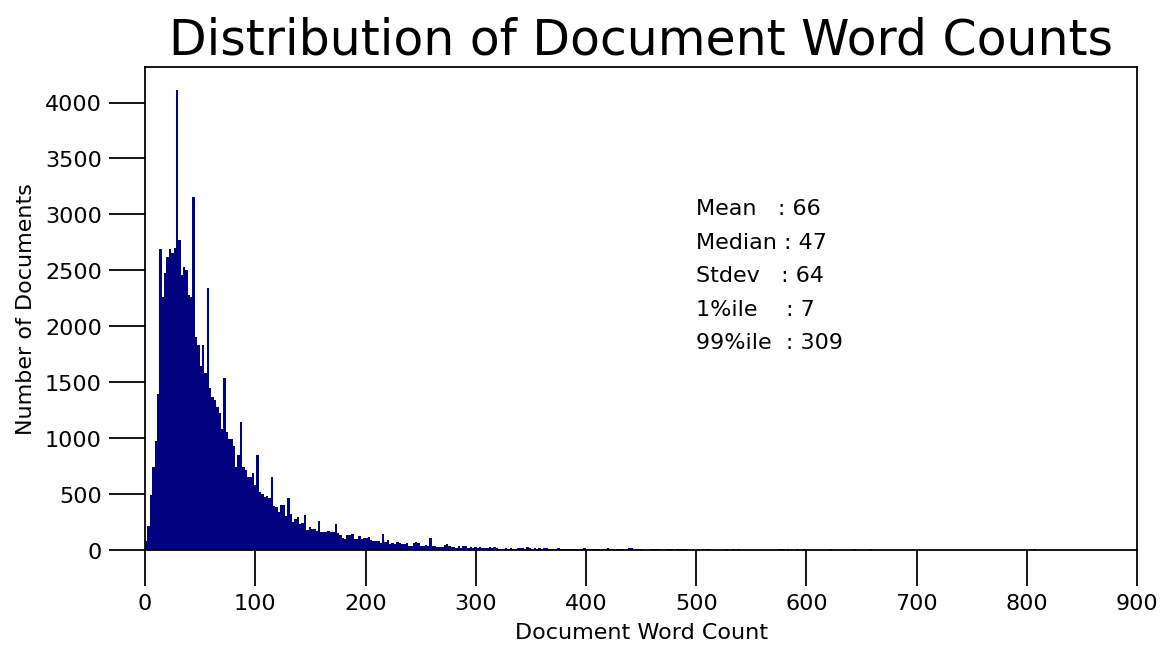

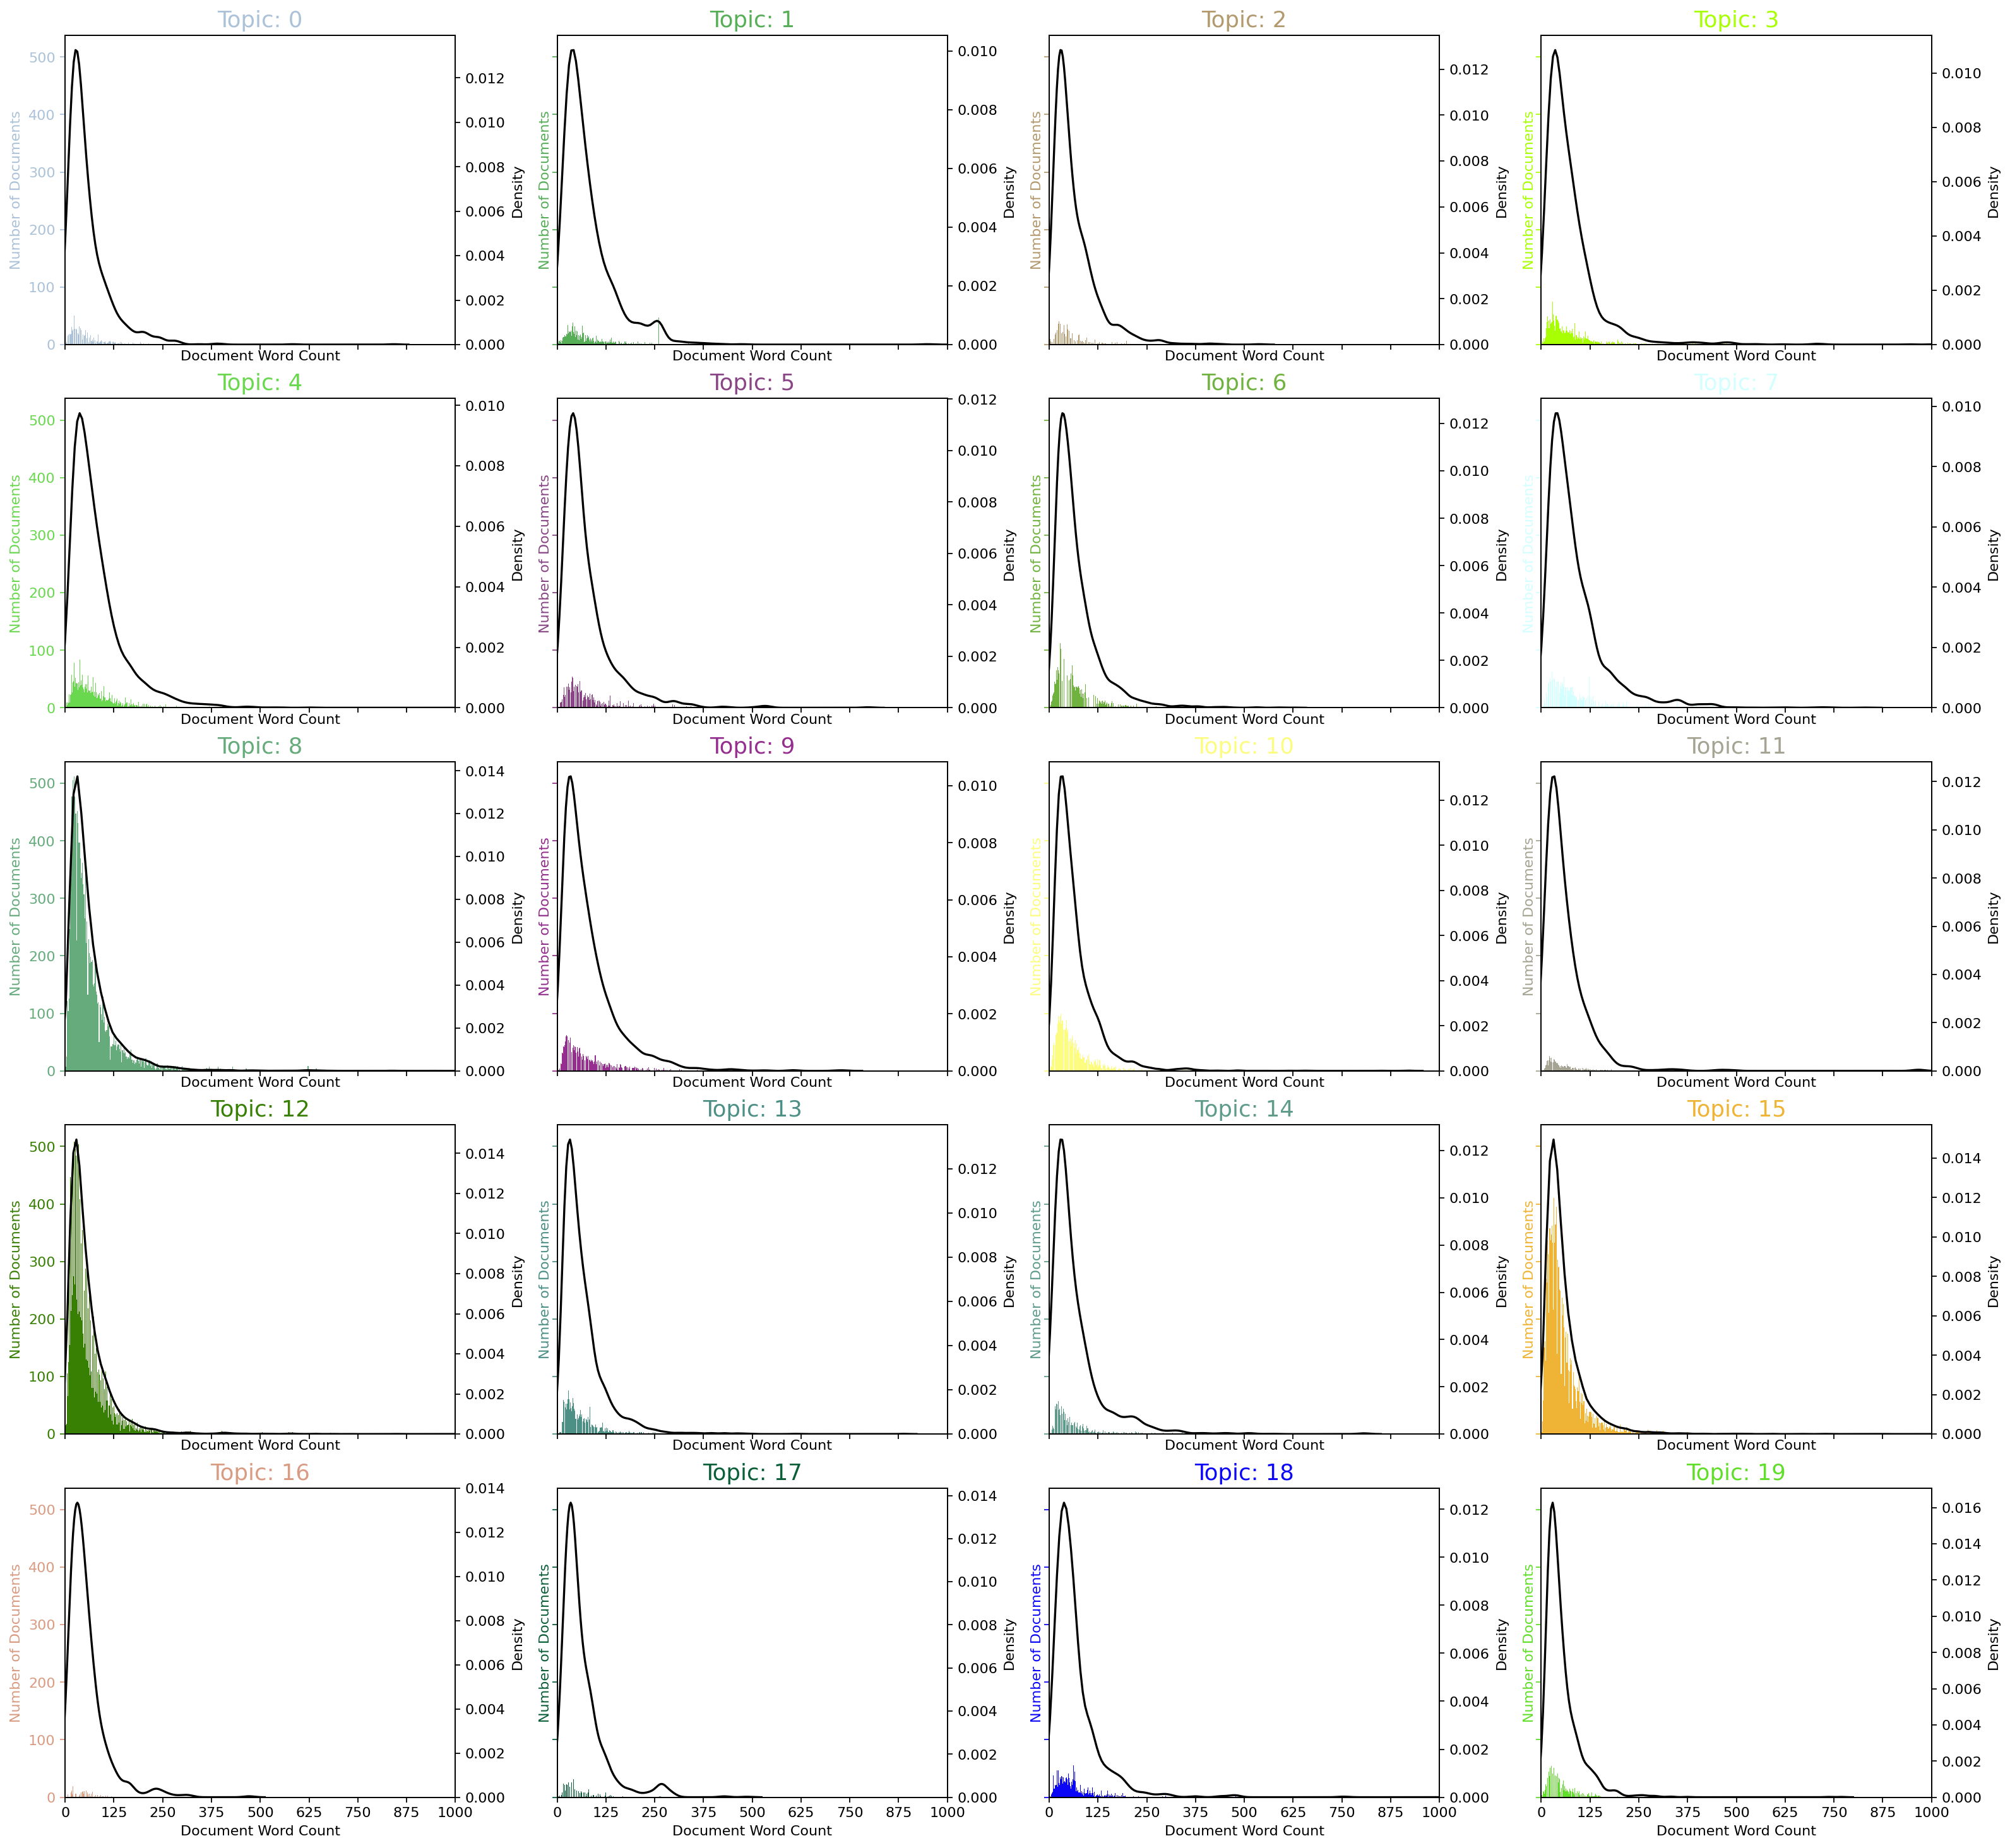

In [ ]:

'''
8. Frequency Distribution of Word Counts in Documents

When working with a large number of documents, we want to know how big the documents are as a whole and by topic.
Let’s plot the document word counts distribution.
'''


doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(8,4), dpi=160)
plt.hist(doc_lens, bins = 900, color='navy')
plt.text(500, 3000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(500, 2700, "Median : " + str(round(np.median(doc_lens))))

plt.text(500, 2400, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(500, 2100, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))

plt.text(500, 1800, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))


plt.gca().set(xlim=(0, 900), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,900,10))

plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()




import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5, 4, figsize=(20, 20), dpi=160, sharex=True, sharey=True)


for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]

    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))

## fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()



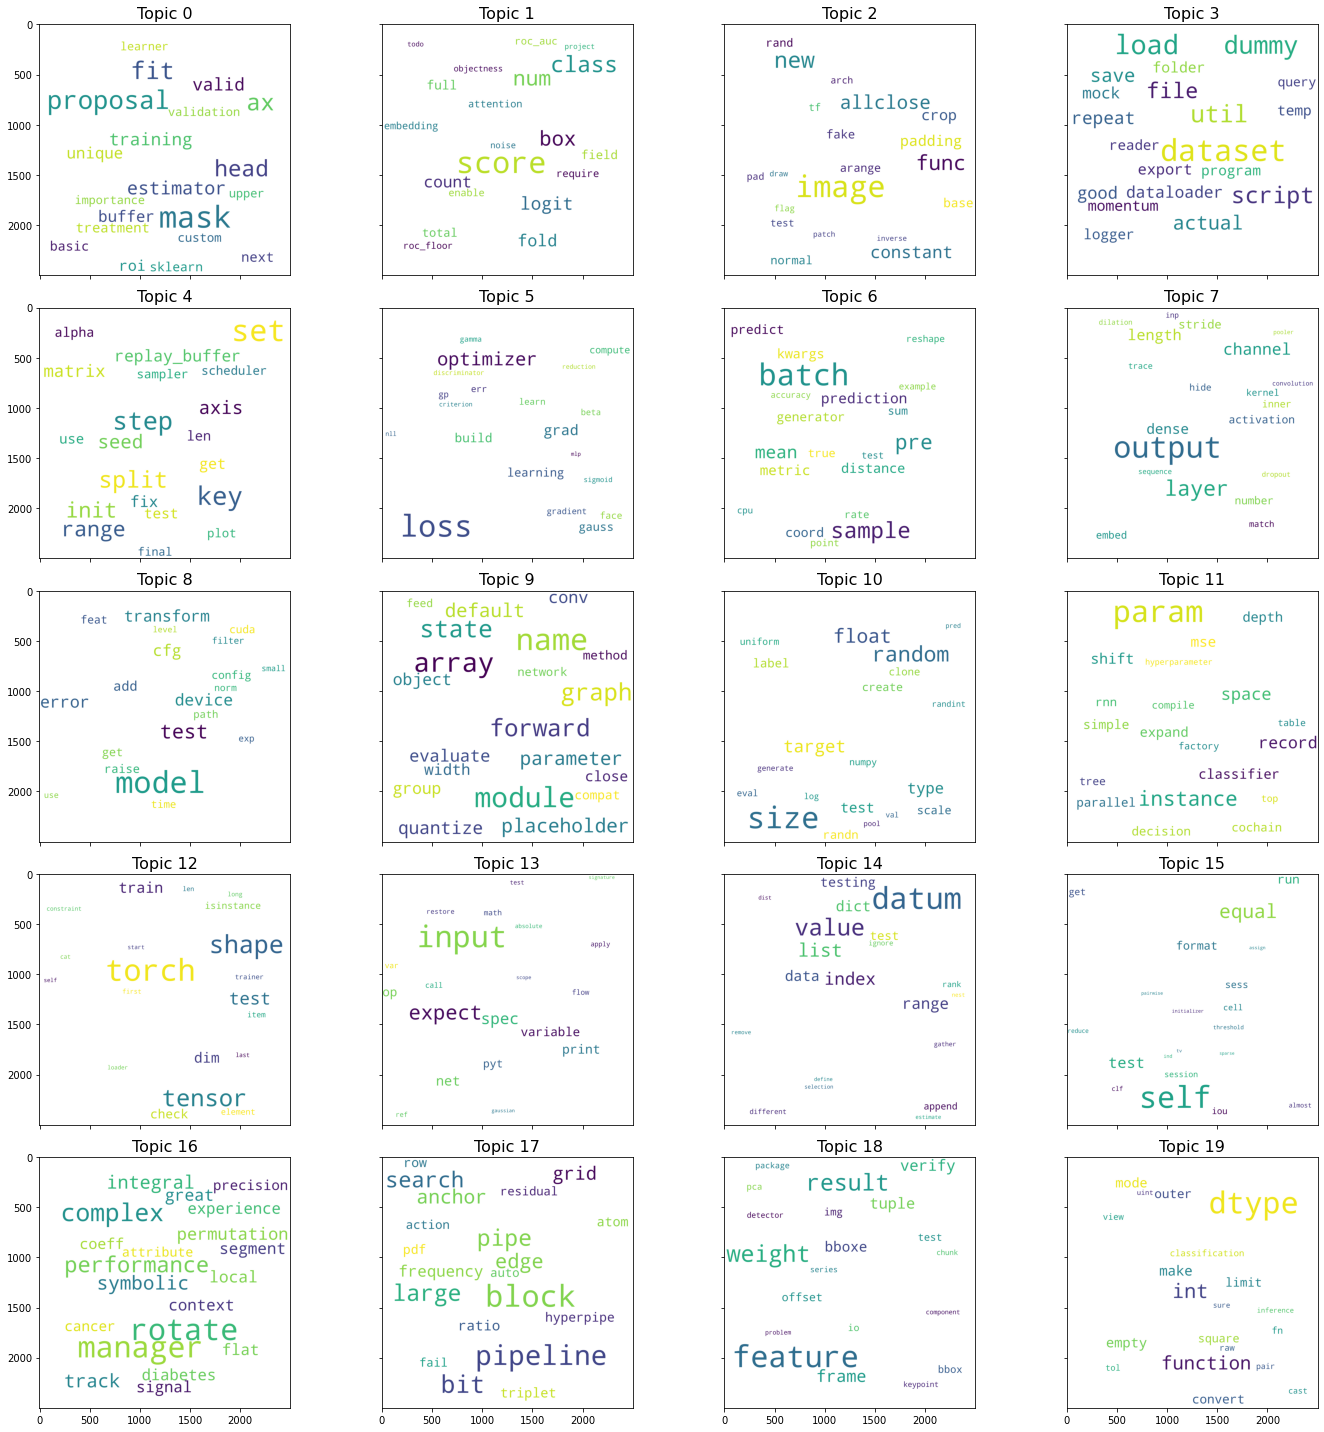

In [ ]:


'''
9. Word Clouds of Top N Keywords in Each Topic

Aword cloud with the size of the words proportional to the weight is a pleasant sight.
The coloring of the topics I’ve taken here is followed in the subsequent plots as well.
'''


# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=2500,
                  max_words=20,
                  #colormap='tab10',
                  #color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=20, num_words=20)


fig, axes = plt.subplots(5, 4, figsize=(20, 20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)

    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('on')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('on')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()



Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

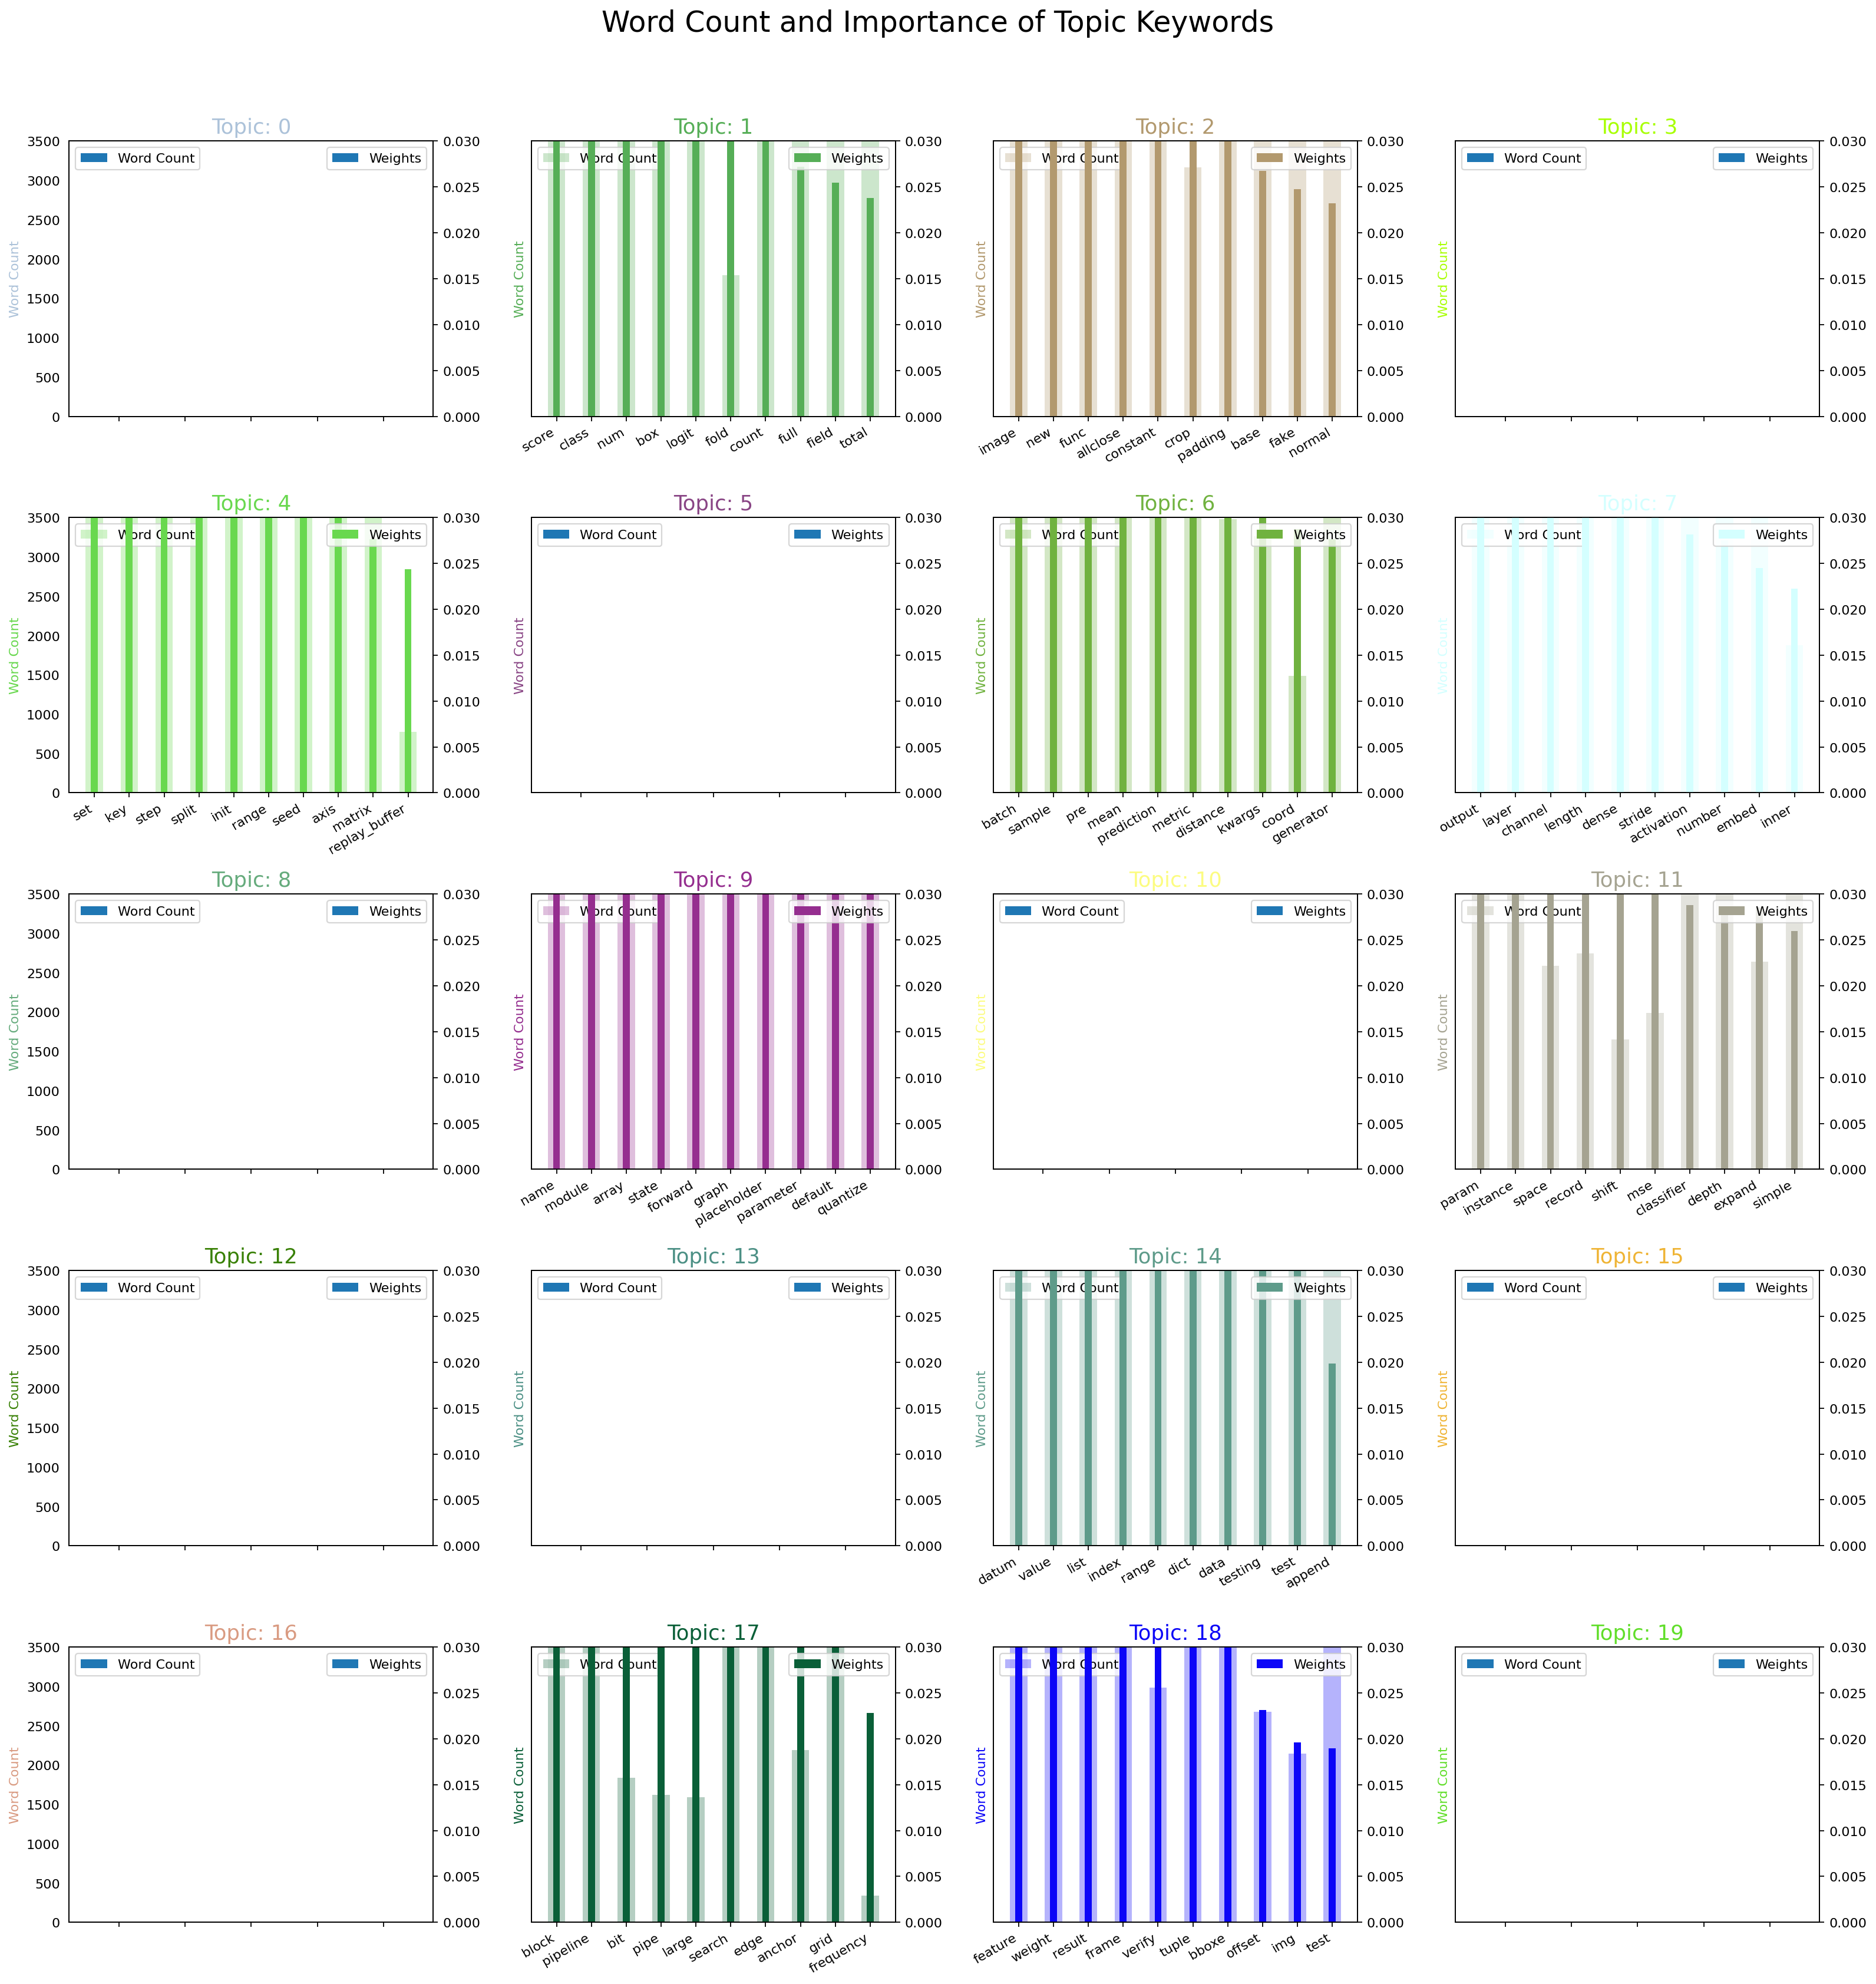

In [ ]:

'''
10. Word Counts of Topic Keywords

When it comes to the keywords in the topics, the importance (weights) of the keywords matters.
Along with that, how frequently the words have appeared in the documents is also interesting to look.
Let’s plot the word counts and the weights of each keyword in the same chart.
We want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight.
Often such words turn out to be less important.
The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.
'''

from collections import Counter
topics = optimal_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 4, figsize=(20, 20), sharey=True, dpi=160)
cols = [color for name, color in mcolors.XKCD_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)



In [ ]:

'''
11. Sentence Chart Colored by Topic

Each word in the document is representative of one of the 20 topics.
Let’s color each word in the given documents by the topic id it is attributed to.
The color of the enclosing rectangle is the topic assigned to the document.
'''


# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=optimal_model, corpus=corpus, start = 0, end = 21):

    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]


    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1]
            topic_percs, wordid_topics, wordid_phivalues = optimal_model[corp_cur]
            word_dominanttopic = [(optimal_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, color=mycolors[topic_percs_sorted[0][0]], linewidth=2))


            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16,
                            color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
                    ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()



ValueError: ignored

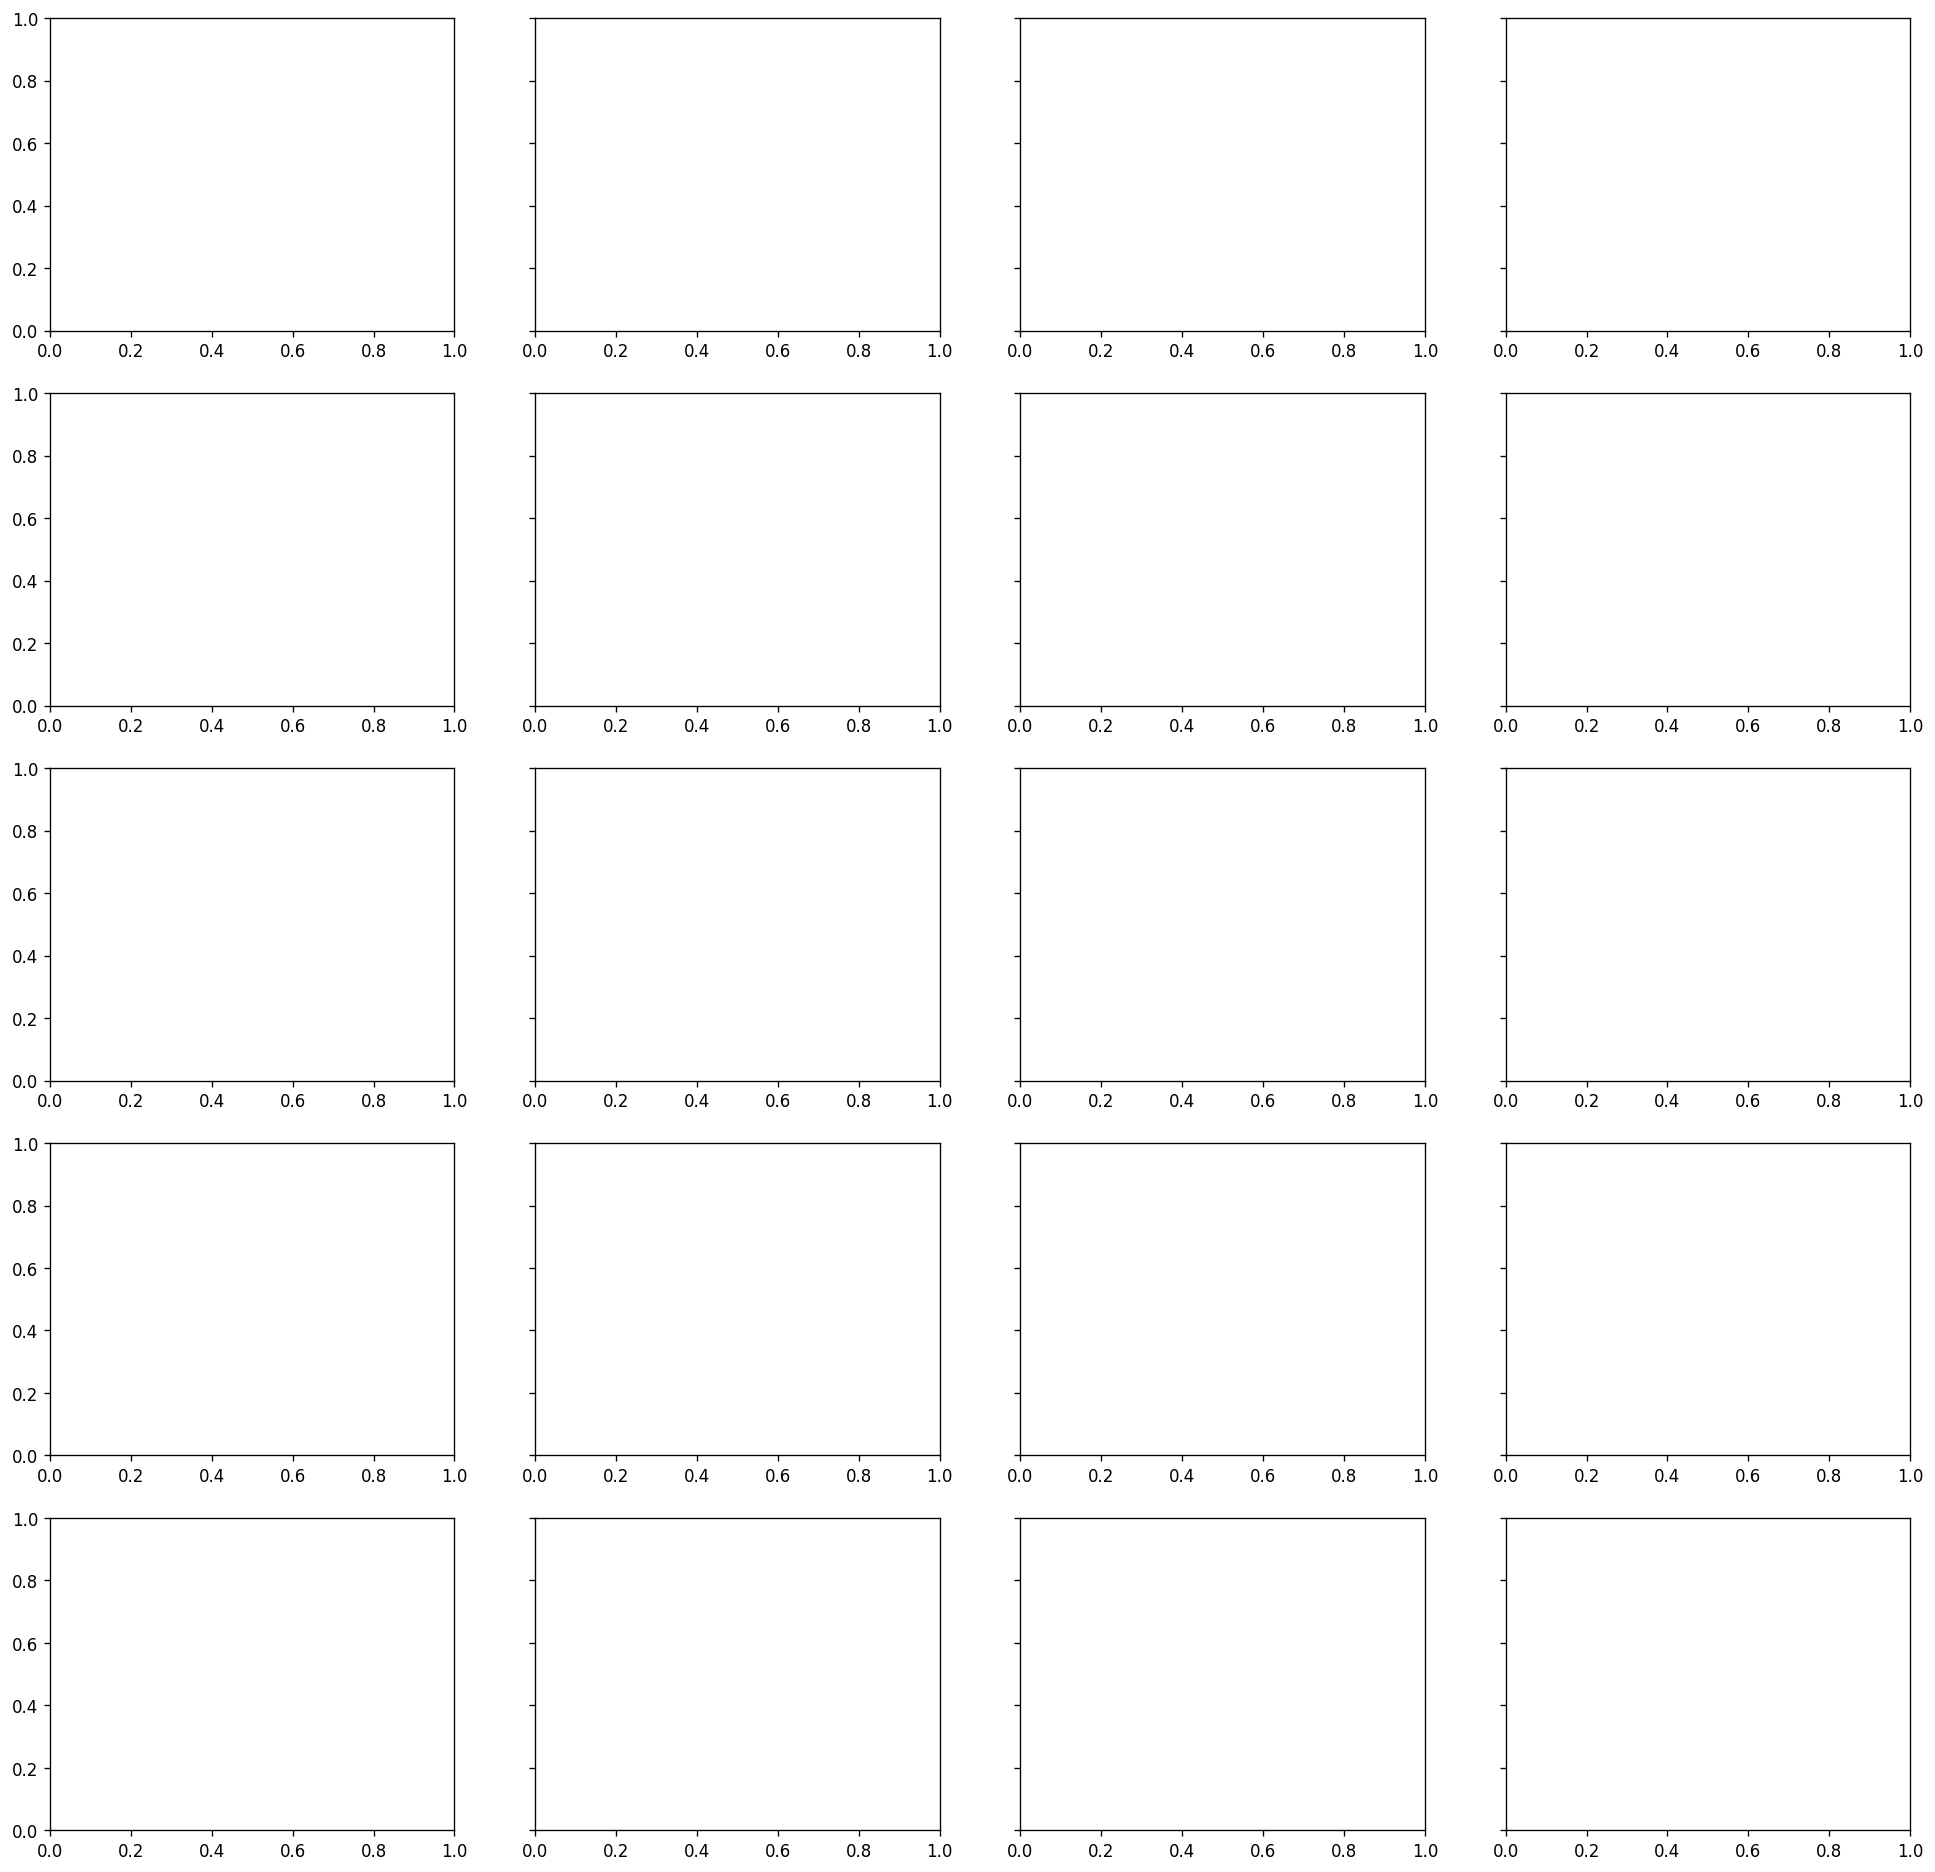

In [ ]:


'''
12. What are the most discussed topics in the documents?
Let’s compute the total number of documents attributed to each topic.
'''


# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=21):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)

    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=optimal_model, corpus=corpus, end=-1)


# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()


# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()


# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in optimal_model.show_topics(formatted=False) for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)



'''
Left:  The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
Right: The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.
'''

from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(5, 4, figsize=(20, 20), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()




In [ ]:

'''
13. t-SNE Clustering Chart
Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.
'''


# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus]):

    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values


# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 6
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)


'''
14. pyLDAVis
pyLDAVis is the most commonly used and a nice way to visualise the information contained in a topic model.
Below is the implementation for LdaModel().
'''

import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, corpus, id2word)
vis


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13661 samples in 0.001s...
[t-SNE] Computed neighbors for 13661 samples in 3.265s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13661
[t-SNE] Computed conditional probabilities for sample 2000 / 13661
[t-SNE] Computed conditional probabilities for sample 3000 / 13661
[t-SNE] Computed conditional probabilities for sample 4000 / 13661
[t-SNE] Computed conditional probabilities for sample 5000 / 13661
[t-SNE] Computed conditional probabilities for sample 6000 / 13661
[t-SNE] Computed conditional probabilities for sample 7000 / 13661
[t-SNE] Computed conditional probabilities for sample 8000 / 13661
[t-SNE] Computed conditional probabilities for sample 9000 / 13661
[t-SNE] Computed conditional probabilities for sample 10000 / 13661
[t-SNE] Computed conditional probabilities for sample 11000 / 13661
[t-SNE] Computed conditional probabilities for sample 12000 / 13661
[t-SNE] Computed conditional probabilities for sam

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.216156
[t-SNE] KL divergence after 1000 iterations: 1.433312


IndexError: ignored

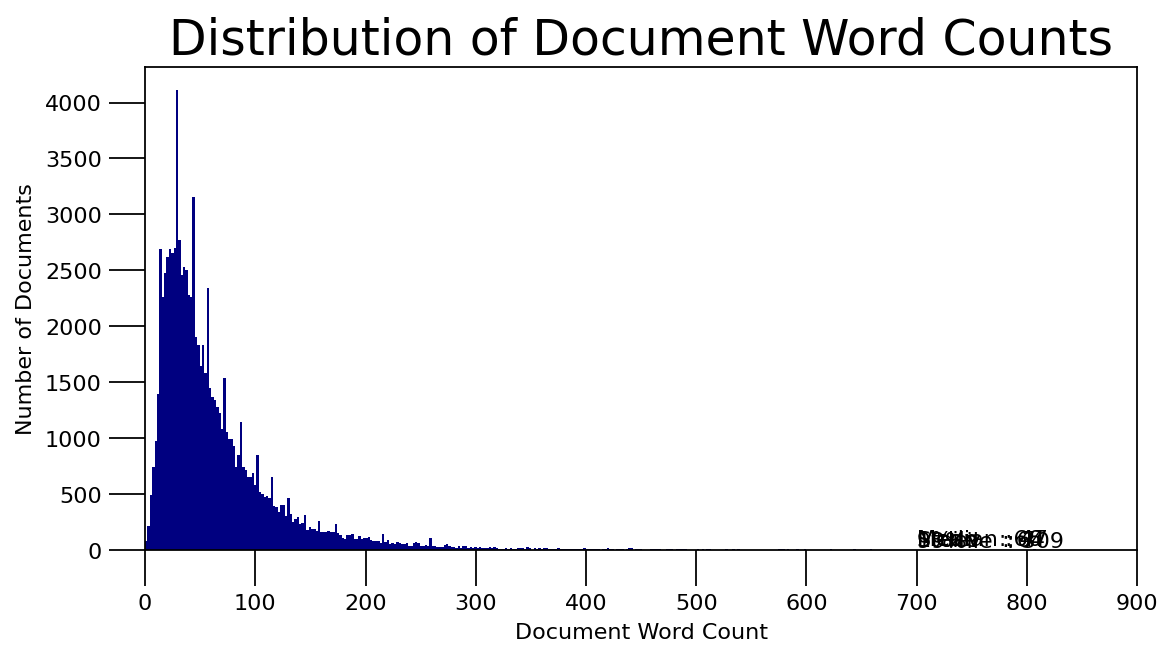

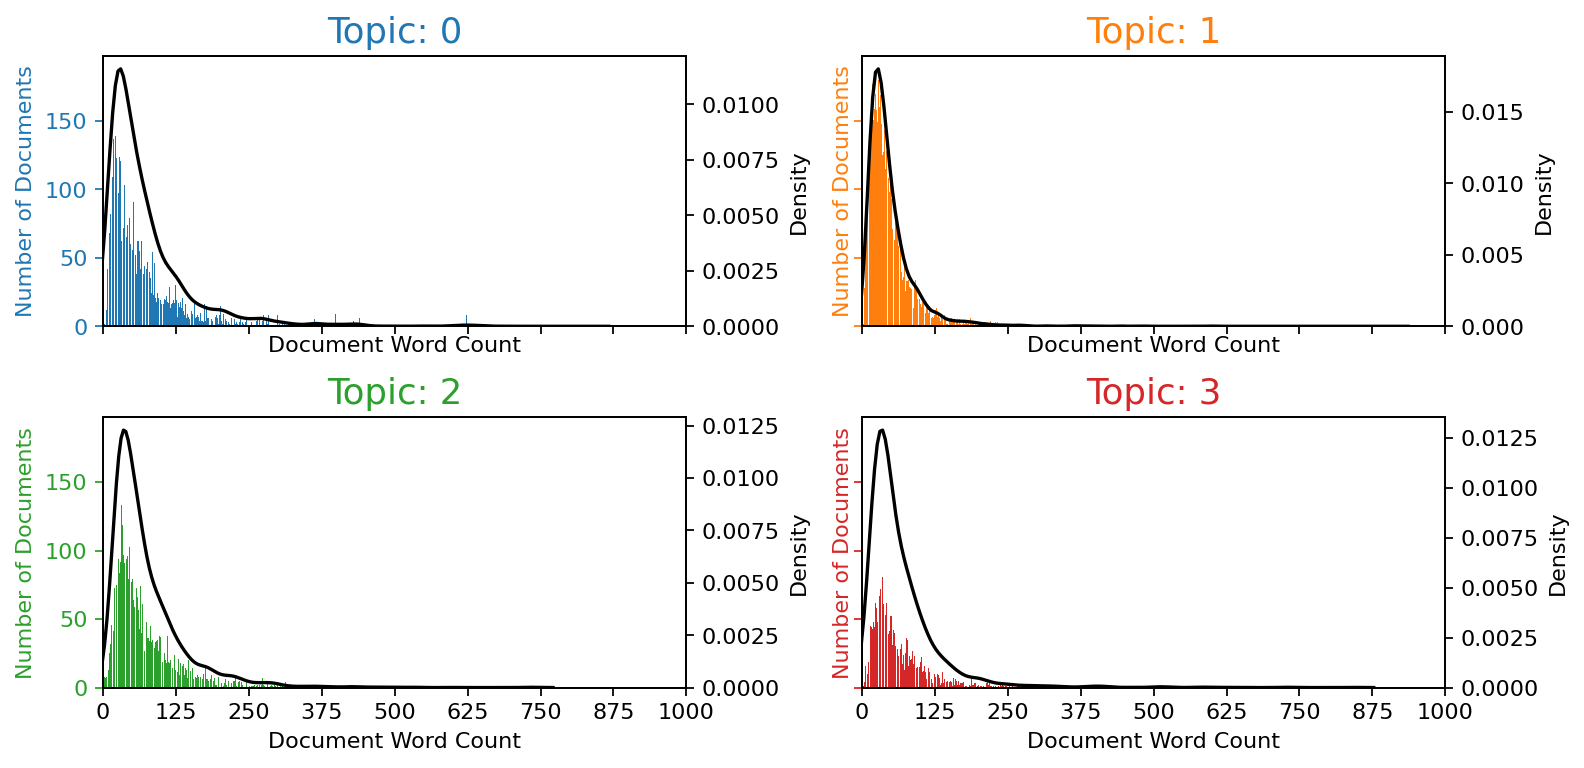

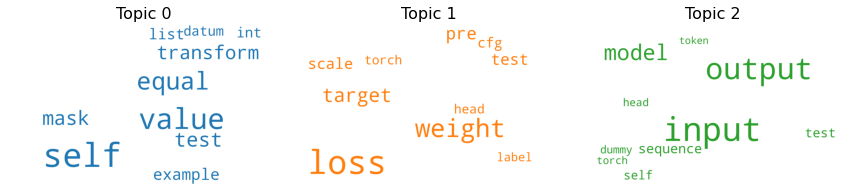

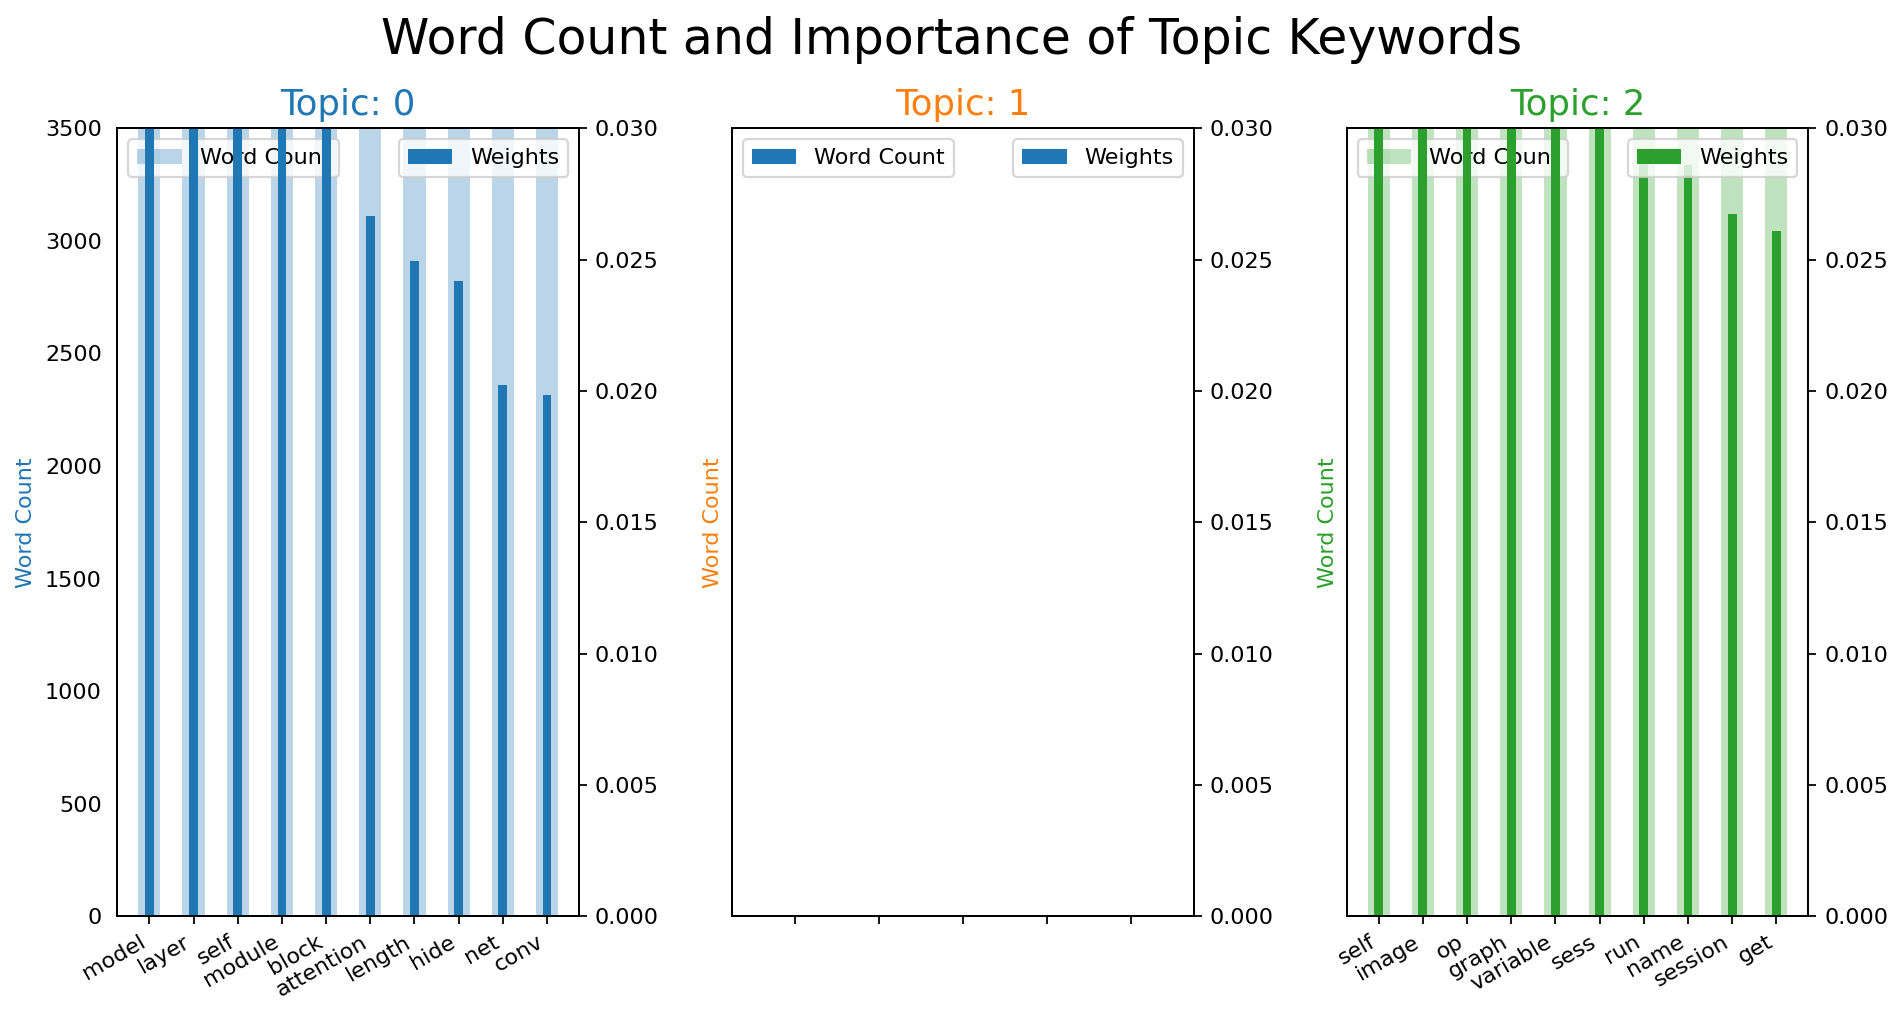

IndexError: ignored

<Figure size 1200x480 with 2 Axes>

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9265 samples in 0.018s...
[t-SNE] Computed neighbors for 9265 samples in 1.597s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9265
[t-SNE] Computed conditional probabilities for sample 2000 / 9265
[t-SNE] Computed conditional probabilities for sample 3000 / 9265
[t-SNE] Computed conditional probabilities for sample 4000 / 9265
[t-SNE] Computed conditional probabilities for sample 5000 / 9265
[t-SNE] Computed conditional probabilities for sample 6000 / 9265
[t-SNE] Computed conditional probabilities for sample 7000 / 9265
[t-SNE] Computed conditional probabilities for sample 8000 / 9265
[t-SNE] Computed conditional probabilities for sample 9000 / 9265
[t-SNE] Computed conditional probabilities for sample 9265 / 9265
[t-SNE] Mean sigma: 0.000105


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.429016
[t-SNE] KL divergence after 1000 iterations: 0.999409


IndexError: ignored

In [ ]:

'''
6. What is the Dominant topic and its percentage contribution in each document

In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant.
The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.
This way, you will know which document belongs predominantly to which topic.
'''

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):

    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.
Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)

            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    names = pd.Series(doc_names)

    sent_topics_df = pd.concat([sent_topics_df, contents, names], axis=1)
    ## sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(
ldamodel=optimal_model, corpus=corpus, texts=data_ready)


# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()

df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Name']

'''
7. The most representative sentence for each topic
Sometimes you want to get samples of sentences that most represent a given topic. This code gets the most exemplar sentence for each topic.
'''

# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text", "Title"]

# Show
sent_topics_sorteddf_mallet.head(10)


'''
8. Frequency Distribution of Word Counts in Documents

When working with a large number of documents, we want to know how big the documents are as a whole and by topic.
Let’s plot the document word counts distribution.
'''


doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(8,4), dpi=160)
plt.hist(doc_lens, bins = 900, color='navy')
plt.text(700, 45, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(700, 40, "Median : " + str(round(np.median(doc_lens))))

plt.text(700, 35, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(700, 30, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))

plt.text(700, 25, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))


plt.gca().set(xlim=(0, 900), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,900,10))

plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()




import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(10,5), dpi=160, sharex=True, sharey=True)


for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]

    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))

## fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()


'''
9. Word Clouds of Top N Keywords in Each Topic

Aword cloud with the size of the words proportional to the weight is a pleasant sight.
The coloring of the topics I’ve taken here is followed in the subsequent plots as well.
'''


# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1500,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)


fig, axes = plt.subplots(1,3, figsize=(12,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)

    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


'''
10. Word Counts of Topic Keywords

When it comes to the keywords in the topics, the importance (weights) of the keywords matters.
Along with that, how frequently the words have appeared in the documents is also interesting to look.
Let’s plot the word counts and the weights of each keyword in the same chart.
We want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight.
Often such words turn out to be less important.
The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.
'''

from collections import Counter
topics = optimal_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(1, 3, figsize=(12,6), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)


'''
11. Sentence Chart Colored by Topic

Each word in the document is representative of one of the 4 topics.
Let’s color each word in the given documents by the topic id it is attributed to.
The color of the enclosing rectangle is the topic assigned to the document.
'''


# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=
optimal_model, corpus=corpus, start = 0, end = 11):

    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()
]


    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1]
            topic_percs, wordid_topics, wordid_phivalues = optimal_model[corp_cur]
            word_dominanttopic = [(optimal_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1,
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))


            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
                    ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()



'''
12. What are the most discussed topics in the documents?
Let’s compute the total number of documents attributed to each topic.
'''


# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)

    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=
optimal_model, corpus=corpus, end=-1)


# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()


# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()


# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in optimal_model.show_topics(formatted=False) for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)



'''
Left:  The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
Right: The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.
'''

from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()


'''
13. t-SNE Clustering Chart
Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.
'''


# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus]):

    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values


# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 6
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)


'''
14. pyLDAVis
pyLDAVis is the most commonly used and a nice way to visualise the information contained in a topic model.
Below is the implementation for LdaModel().
'''

import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, corpus, id2word)
vis



In [ ]:

'''
13. t-SNE Clustering Chart
Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.
'''


# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus]):

    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values


# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 6
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)


'''
14. pyLDAVis
pyLDAVis is the most commonly used and a nice way to visualise the information contained in a topic model.
Below is the implementation for LdaModel().
'''

import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, corpus, id2word)
vis


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9265 samples in 0.018s...
[t-SNE] Computed neighbors for 9265 samples in 1.589s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9265
[t-SNE] Computed conditional probabilities for sample 2000 / 9265
[t-SNE] Computed conditional probabilities for sample 3000 / 9265
[t-SNE] Computed conditional probabilities for sample 4000 / 9265
[t-SNE] Computed conditional probabilities for sample 5000 / 9265
[t-SNE] Computed conditional probabilities for sample 6000 / 9265
[t-SNE] Computed conditional probabilities for sample 7000 / 9265
[t-SNE] Computed conditional probabilities for sample 8000 / 9265
[t-SNE] Computed conditional probabilities for sample 9000 / 9265
[t-SNE] Computed conditional probabilities for sample 9265 / 9265
[t-SNE] Mean sigma: 0.000117


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.431427
[t-SNE] KL divergence after 1000 iterations: 1.005465


IndexError: ignored

In [ ]:
imUsingColab = True

if imUsingColab:
    !pip install gensim
    !pip install pyLDAvis
    !pip install vega
    !pip install altair


import re
import spacy

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

# import numpy for matrix operation
import numpy as np


from pprint import pprint
import pandas as pd

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

## from google.colab import drive
## drive.mount('/content/drive/')

##!unzip -uq "/content/Names_207039.zip" -d "/content/"
## !unzip -uq "/content/test_names_220610" -d "/content/"
!unzip -uq "/content/mallet-2.0.8.zip" -d "/content/"
## !unzip -uq "/content/reviews_words.zip" -d "/content/"
!unzip -uq "/content/test_name.zip" -d "/content/"

##dirpath = '/content/Names_207039/'
## dirpath = '/content/test_names/
## dirpath = '/content/reviews_words/'
dirpath = '/content/test_name/'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

import os
## Setup mallet environment change it according to your drive
os.environ.update({'MALLET_HOME':r'/content/mallet-2.0.8'})
## Setup mallet path change it according to your drive

files = [os.path.join(dirpath, fname) for fname in os.listdir(dirpath)]
corpus_text = []

for filename in sorted(files):
    with open(filename, 'r') as f:
        corpus_text += [f.read()]




from pathlib import Path

doc_names = [Path(file).stem for file in sorted(files)]

# Apply Preprocessing on the Corpus

# Apply Preprocessing on the Corpus

import nltk

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

# stop loss words
stop = set(stopwords.words('english'))

# punctuation
exclude = set(string.punctuation)

# lemmatization
lemma = WordNetLemmatizer()

# One function for all the steps:
def clean(doc):

    doc = re.sub("([^\x00-\x7F])+"," ", str(doc))
    ## doc = re.sub(r'\b\d+(?:\.\d+)?\s+', '', str(doc))
    ## print(doc)
    # convert text into lower case + split into words
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])

    for z in stop_free:

      ## string = 'abcd1234efg567'
      z = re.sub(r'\b\d+(?:\.\d+)?\s+', '', str(z))

      newstring = ''.join([i for i in z if not i.isdigit()]).lower()
      if not(len(newstring) < 2):
          ## print(newstring)
          stringVal = stringVal + " " + newstring

    # remove any stop words present
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)

    # remove punctuations + normalize the text
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split() if not word.isdigit())
    return normalized

# clean data stored in a new list
clean_corpus    = [clean(doc).split() for doc in corpus_text]
## data_lemmatized = [clean(doc).split() for doc in corpus]

# Create Dictionary
##id2word = corpora.Dictionary(data_lemmatized)
id2word = corpora.Dictionary(clean_corpus)

# Create Corpus
texts = clean_corpus

##

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]]


from nltk.corpus import stopwords
stop_words = stopwords.words('english')
## stop_words.extend(['for', 'and', 'to', 'the', 'you', 'not', 'from', 'subject', 're', 'edu', 'use'])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(texts, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[texts], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    ## nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

data_ready = process_words(texts)  # processed Text Data!

'''
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]
'''

# Build LDA model
'''
lda_model = gensim.models.wrappers.LdaMallet(mallet_path,
                                          corpus=corpus,
                                          num_topics=4,
                                          ## alpha=1/num_topics,
                                          alpha=50/4,
                                          id2word=id2word,
                                          workers=40,
                                          optimize_interval=4,
                                          iterations=500)
                                          ##iterations=1500)




lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)


pprint(lda_model.print_topics())
'''

'''
# Converting list of documents (corpus) into Document Term Matrix using the dictionary
doc_term_matrix = [id2word.doc2bow(i) for i in clean_corpus]
doc_term_matrix


nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
## stop_words.extend(['for', 'and', 'to', 'the', 'you', 'not', 'from', 'subject', 're', 'edu', 'use'])

from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize


def flattern(doc):

    # split into words
    split_into_words = " ".join([i for i in doc.split() if not i.isdigit()])
    ## split_into_words = " ".join([i for i in doc.split()])

    return split_into_words

# Saving data in a new list
texts = [flattern(doc).split() for doc in corpus_text]

##
##def remove_stopwords(texts):
  ##for text in texts:
    ##return [word for word in simple_preprocess(str(text)) if word not in stop_words]
##

## text = "Nick likes to play football, however he is not too fond of tennis."
for text in texts:
  text_tokens = word_tokenize(str(text))
  text = [word for word in text_tokens if not word in stop_words]
  ## text = [word for word in text_tokens if not word in stopwords.words()]

  ## print(text)

##for doc in corpus_text:
## texts = remove_stopwords(texts)
## corpus = remove_stopwords(list(texts))

# Create Dictionary
id2word = corpora.Dictionary(texts)
## id2word.filter_extremes(no_below=15, no_above=0.4, keep_n=80000)

# Term Document Frequency
# https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html

corpus = [id2word.doc2bow(text) for text in texts]

##corpus = [TaggedDocument(simple_preprocess(text), [i])
                  ##for i, text in enumerate(texts)]

#### apply(lambda x: gensim.parsing.preprocessing.remove_stopwords(" ".join(x)))

'''

'''
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):


        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

        '''
        '''
        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                                 corpus=corpus,
                                                 num_topics=num_topics,
                                                 ## alpha=1/num_topics,
                                                 alpha=50/num_topics,
                                                 id2word=id2word,
                                                 workers=40,
                                                 optimize_interval=4,
                                                 iterations=500)
                                                 ##iterations=1500)

        lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
        '''
       '''
        model_list.append(lda_model)

        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        ## coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit=30, step=1)



import csv

with open('/content/lda_cv.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    header = ['K', 'CV']
    writer.writerow(header)

    limit=30; start=2; step=1;

    x = range(start, limit, step)
    # Show graph

    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()


    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
        data = [m, round(cv, 4)]
        writer.writerow(data)

'''

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 14.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=bd66512dbf39ad8324abf0d11cd0b48075d4cd85d4316881748e8dacf3f719d8
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=2120f2e749bc1fba56791001a0644911a4014ead160b1e2cbb3336dd306ea8bf
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn
Looking in 

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [ ]:


'''
imUsingColab = True

if imUsingColab:
    !pip install gensim
    !pip install pyLDAvis
    !pip install vega
    !pip install altair


import re
import spacy

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

# import numpy for matrix operation
import numpy as np


from pprint import pprint
import pandas as pd

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

## from google.colab import drive
## drive.mount('/content/drive/')

##!unzip -uq "/content/Names_207039.zip" -d "/content/"
## !unzip -uq "/content/test_names_220610" -d "/content/"
!unzip -uq "/content/mallet-2.0.8.zip" -d "/content/"
## !unzip -uq "/content/reviews_words.zip" -d "/content/"
!unzip -uq "/content/test_name.zip" -d "/content/"

##dirpath = '/content/Names_207039/'
## dirpath = '/content/test_names/
## dirpath = '/content/reviews_words/'
dirpath = '/content/test_name/'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

import os
## Setup mallet environment change it according to your drive
os.environ.update({'MALLET_HOME':r'/content/mallet-2.0.8'})
## Setup mallet path change it according to your drive

files = [os.path.join(dirpath, fname) for fname in os.listdir(dirpath)]
corpus_text = []

for filename in sorted(files):
    with open(filename, 'r') as f:
        corpus_text += [f.read()]




from pathlib import Path

doc_names = [Path(file).stem for file in sorted(files)]

# Apply Preprocessing on the Corpus

# Apply Preprocessing on the Corpus

import nltk

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

# stop loss words
stop = set(stopwords.words('english'))

# punctuation
exclude = set(string.punctuation)

# lemmatization
lemma = WordNetLemmatizer()

# One function for all the steps:
def clean(doc):

    doc = re.sub("([^\x00-\x7F])+"," ", str(doc))
    ## doc = re.sub(r'\b\d+(?:\.\d+)?\s+', '', str(doc))
    ## print(doc)
    # convert text into lower case + split into words
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])

    for z in stop_free:

      ## string = 'abcd1234efg567'
      z = re.sub(r'\b\d+(?:\.\d+)?\s+', '', str(z))

      newstring = ''.join([i for i in z if not i.isdigit()]).lower()
      if not(len(newstring) < 2):
          ## print(newstring)
          stringVal = stringVal + " " + newstring

    # remove any stop words present
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)

    # remove punctuations + normalize the text
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split() if not word.isdigit())
    return normalized

# clean data stored in a new list
clean_corpus    = [clean(doc).split() for doc in corpus_text]
## data_lemmatized = [clean(doc).split() for doc in corpus]

# Create Dictionary
##id2word = corpora.Dictionary(data_lemmatized)
id2word = corpora.Dictionary(clean_corpus)

# Create Corpus
texts = clean_corpus

##

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]]


from nltk.corpus import stopwords
stop_words = stopwords.words('english')
## stop_words.extend(['for', 'and', 'to', 'the', 'you', 'not', 'from', 'subject', 're', 'edu', 'use'])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(texts, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[texts], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    ## nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

data_ready = process_words(texts)  # processed Text Data!

'''
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
'''
lda_model = gensim.models.wrappers.LdaMallet(mallet_path,
                                          corpus=corpus,
                                          num_topics=4,
                                          ## alpha=1/num_topics,
                                          alpha=50/4,
                                          id2word=id2word,
                                          workers=40,
                                          optimize_interval=4,
                                          iterations=500)
                                          ##iterations=1500)




lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)


pprint(lda_model.print_topics())
'''

'''
# Converting list of documents (corpus) into Document Term Matrix using the dictionary
doc_term_matrix = [id2word.doc2bow(i) for i in clean_corpus]
doc_term_matrix


nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
## stop_words.extend(['for', 'and', 'to', 'the', 'you', 'not', 'from', 'subject', 're', 'edu', 'use'])

from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize


def flattern(doc):

    # split into words
    split_into_words = " ".join([i for i in doc.split() if not i.isdigit()])
    ## split_into_words = " ".join([i for i in doc.split()])

    return split_into_words

# Saving data in a new list
texts = [flattern(doc).split() for doc in corpus_text]

##
##def remove_stopwords(texts):
  ##for text in texts:
    ##return [word for word in simple_preprocess(str(text)) if word not in stop_words]
##

## text = "Nick likes to play football, however he is not too fond of tennis."
for text in texts:
  text_tokens = word_tokenize(str(text))
  text = [word for word in text_tokens if not word in stop_words]
  ## text = [word for word in text_tokens if not word in stopwords.words()]

  ## print(text)

##for doc in corpus_text:
## texts = remove_stopwords(texts)
## corpus = remove_stopwords(list(texts))

# Create Dictionary
id2word = corpora.Dictionary(texts)
## id2word.filter_extremes(no_below=15, no_above=0.4, keep_n=80000)

# Term Document Frequency
# https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html

corpus = [id2word.doc2bow(text) for text in texts]

##corpus = [TaggedDocument(simple_preprocess(text), [i])
                  ##for i, text in enumerate(texts)]

#### apply(lambda x: gensim.parsing.preprocessing.remove_stopwords(" ".join(x)))

'''


def compute_coherence_values(dictionary, corpus, texts, limit, start, step):

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):


        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

        '''
        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                                 corpus=corpus,
                                                 num_topics=num_topics,
                                                 ## alpha=1/num_topics,
                                                 alpha=50/num_topics,
                                                 id2word=id2word,
                                                 workers=40,
                                                 optimize_interval=4,
                                                 iterations=500)
                                                 ##iterations=1500)

        lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
        '''

        model_list.append(lda_model)

        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        ## coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit=30, step=1)



import csv

with open('/content/lda_cv.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    header = ['K', 'CV']
    writer.writerow(header)

    limit=30; start=2; step=1;

    x = range(start, limit, step)
    # Show graph

    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()


    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
        data = [m, round(cv, 4)]
        writer.writerow(data)



In [ ]:
imUsingColab = True

if imUsingColab:
    !pip install gensim
    !pip install pyLDAvis
    !pip install vega
    !pip install altair


import re
import spacy

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

# import numpy for matrix operation
import numpy as np


from pprint import pprint
import pandas as pd

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

## from google.colab import drive
## drive.mount('/content/drive/')

##!unzip -uq "/content/Names_207039.zip" -d "/content/"
## !unzip -uq "/content/test_names_220610" -d "/content/"
!unzip -uq "/content/mallet-2.0.8.zip" -d "/content/"
## !unzip -uq "/content/reviews_words.zip" -d "/content/"
!unzip -uq "/content/test_name.zip" -d "/content/"

##dirpath = '/content/Names_207039/'
## dirpath = '/content/test_names/
## dirpath = '/content/reviews_words/'
dirpath = '/content/test_name/'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

import os
## Setup mallet environment change it according to your drive
os.environ.update({'MALLET_HOME':r'/content/mallet-2.0.8'})
## Setup mallet path change it according to your drive

files = [os.path.join(dirpath, fname) for fname in os.listdir(dirpath)]
corpus_text = []

for filename in sorted(files):
    with open(filename, 'r') as f:
        corpus_text += [f.read()]




from pathlib import Path

doc_names = [Path(file).stem for file in sorted(files)]

# Apply Preprocessing on the Corpus

# Apply Preprocessing on the Corpus

import nltk

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

# stop loss words
stop = set(stopwords.words('english'))

# punctuation
exclude = set(string.punctuation)

# lemmatization
lemma = WordNetLemmatizer()

# One function for all the steps:
def clean(doc):

    doc = re.sub("([^\x00-\x7F])+"," ", str(doc))
    ## doc = re.sub(r'\b\d+(?:\.\d+)?\s+', '', str(doc))
    ## print(doc)
    # convert text into lower case + split into words
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])

    for z in stop_free:

      ## string = 'abcd1234efg567'
      z = re.sub(r'\b\d+(?:\.\d+)?\s+', '', str(z))

      newstring = ''.join([i for i in z if not i.isdigit()]).lower()
      if not(len(newstring) < 2):
          ## print(newstring)
          stringVal = stringVal + " " + newstring

    # remove any stop words present
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)

    # remove punctuations + normalize the text
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split() if not word.isdigit())
    return normalized

# clean data stored in a new list
clean_corpus    = [clean(doc).split() for doc in corpus_text]
## data_lemmatized = [clean(doc).split() for doc in corpus]

# Create Dictionary
##id2word = corpora.Dictionary(data_lemmatized)
id2word = corpora.Dictionary(clean_corpus)

# Create Corpus
texts = clean_corpus

##

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]]


from nltk.corpus import stopwords
stop_words = stopwords.words('english')
## stop_words.extend(['for', 'and', 'to', 'the', 'you', 'not', 'from', 'subject', 're', 'edu', 'use'])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(texts, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[texts], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    ## nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

data_ready = process_words(texts)  # processed Text Data!


# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
'''
lda_model = gensim.models.wrappers.LdaMallet(mallet_path,
                                          corpus=corpus,
                                          num_topics=4,
                                          ## alpha=1/num_topics,
                                          alpha=50/4,
                                          id2word=id2word,
                                          workers=40,
                                          optimize_interval=4,
                                          iterations=500)
                                          ##iterations=1500)




lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)


pprint(lda_model.print_topics())
'''

'''
# Converting list of documents (corpus) into Document Term Matrix using the dictionary
doc_term_matrix = [id2word.doc2bow(i) for i in clean_corpus]
doc_term_matrix


nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
## stop_words.extend(['for', 'and', 'to', 'the', 'you', 'not', 'from', 'subject', 're', 'edu', 'use'])

from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize


def flattern(doc):

    # split into words
    split_into_words = " ".join([i for i in doc.split() if not i.isdigit()])
    ## split_into_words = " ".join([i for i in doc.split()])

    return split_into_words

# Saving data in a new list
texts = [flattern(doc).split() for doc in corpus_text]

##
##def remove_stopwords(texts):
  ##for text in texts:
    ##return [word for word in simple_preprocess(str(text)) if word not in stop_words]
##

## text = "Nick likes to play football, however he is not too fond of tennis."
for text in texts:
  text_tokens = word_tokenize(str(text))
  text = [word for word in text_tokens if not word in stop_words]
  ## text = [word for word in text_tokens if not word in stopwords.words()]

  ## print(text)

##for doc in corpus_text:
## texts = remove_stopwords(texts)
## corpus = remove_stopwords(list(texts))

# Create Dictionary
id2word = corpora.Dictionary(texts)
## id2word.filter_extremes(no_below=15, no_above=0.4, keep_n=80000)

# Term Document Frequency
# https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html

corpus = [id2word.doc2bow(text) for text in texts]

##corpus = [TaggedDocument(simple_preprocess(text), [i])
                  ##for i, text in enumerate(texts)]

#### apply(lambda x: gensim.parsing.preprocessing.remove_stopwords(" ".join(x)))

'''


def compute_coherence_values(dictionary, corpus, texts, limit, start, step):

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):


        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

        '''
        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                                 corpus=corpus,
                                                 num_topics=num_topics,
                                                 ## alpha=1/num_topics,
                                                 alpha=50/num_topics,
                                                 id2word=id2word,
                                                 workers=40,
                                                 optimize_interval=4,
                                                 iterations=500)
                                                 ##iterations=1500)

        lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
        '''

        model_list.append(lda_model)

        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        ## coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit=30, step=1)



import csv

with open('/content/lda_cv.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    header = ['K', 'CV']
    writer.writerow(header)

    limit=30; start=2; step=1;

    x = range(start, limit, step)
    # Show graph

    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()


    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
        data = [m, round(cv, 4)]
        writer.writerow(data)



In [ ]:
optimal_model = model_list[1]
print(coherence_values[1])

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    names = pd.Series(doc_names)

    sent_topics_df = pd.concat([sent_topics_df, contents, names], axis=1)
    ## sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Name']



In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text", "Title"]

# Show
sent_topics_sorteddf_mallet.head(10)



#################################################################################
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(8,4), dpi=160)
plt.hist(doc_lens, bins = 900, color='navy')
plt.text(700, 45, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(700, 40, "Median : " + str(round(np.median(doc_lens))))
plt.text(700, 35, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(700, 30, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(700, 25, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 900), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,900,10))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()
#################################################################################

import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(10,5), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
## fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()
#################################################################################



# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1500,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(1,3, figsize=(12,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
##################################################################################


from collections import Counter
topics = optimal_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(1, 3, figsize=(12,6), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

####################################################################################


# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=optimal_model, corpus=corpus, start = 0, end = 11):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1]
            topic_percs, wordid_topics, wordid_phivalues = optimal_model[corp_cur]
            word_dominanttopic = [(optimal_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1,
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()
###################################################################################

# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=optimal_model, corpus=corpus, end=-1)

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in optimal_model.show_topics(formatted=False)
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)


from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()
###################################################################################

# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 6
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics),
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

################################################################################
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, corpus, id2word)
vis

################################################################################



In [ ]:
## a = []
## while(1):
  ## a.append('1')
# for text preprocessing
import re
import spacy

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

# import numpy for matrix operation
import numpy as np

# Importing Gensim
import gensim
from gensim import corpora
# to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

!unzip -uq "/content/test_names_220610.zip" -d "/content/"
##





















## !unzip -uq "/content/test_functions_207039.zip" -d "/content/"





In [ ]:
from pathlib import Path

dirpath = '/content/test_names/'

import os

files = [os.path.join(dirpath, fname) for fname in os.listdir(dirpath)]
corpus = []

for filename in sorted(files):
    with open(filename, 'r') as f:
        corpus += [f.read()]

In [ ]:
"""

- K = {5, 10, 15, 20, 25, 30, 35, 40, 45, 50}
- I = {500, 1000, 1500, 2000, 2500}
- alpha = 50/K
- beta  = 0.01

"""

from pathlib import Path

doc_names = [Path(file).stem for file in sorted(files)]

# Apply Preprocessing on the Corpus

import nltk

nltk.download('wordnet')
nltk.download('stopwords')

# stop loss words
stop = set(stopwords.words('english'))

# punctuation
exclude = set(string.punctuation)

# lemmatization
lemma = WordNetLemmatizer()

# One function for all the steps:
def clean(doc):

    # convert text into lower case + split into words
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])

    # remove any stop words present
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)

    # remove punctuations + normalize the text
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

# clean data stored in a new list
data_lemmatized = [clean(doc).split() for doc in corpus]

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Build LDA model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
## lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           ## update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           ## eta=1/20,
                                           eta='auto',
                                           iterations=500,
                                           per_word_topics=True)






[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 29.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=b527981b247839be557719b8ec7823723d5969ec6d3c9b1c1be9eba4225289d9
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

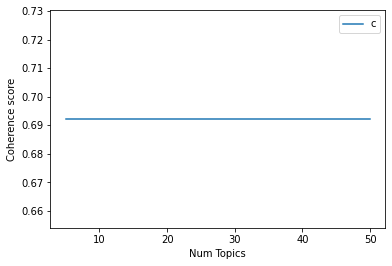

Num Topics = 5  has Coherence Value of 0.6922
Num Topics = 10  has Coherence Value of 0.6922
Num Topics = 15  has Coherence Value of 0.6922
Num Topics = 20  has Coherence Value of 0.6922
Num Topics = 25  has Coherence Value of 0.6922
Num Topics = 30  has Coherence Value of 0.6922
Num Topics = 35  has Coherence Value of 0.6922
Num Topics = 40  has Coherence Value of 0.6922
Num Topics = 45  has Coherence Value of 0.6922
Num Topics = 50  has Coherence Value of 0.6922


In [ ]:
!pip install pyLDAvis

from pprint import pprint
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Converting list of documents (corpus) into Document Term Matrix using the dictionary
doc_term_matrix = [id2word.doc2bow(i) for i in data_lemmatized]


## def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        ## Lda = gensim.models.ldamodel.LdaModel
        Lda = gensim.models.ldamulticore.LdaMulticore
        ## model = Lda(doc_term_matrix, num_topics=num_topics, id2word = id2word, passes=20, alpha=50/num_topics,
           ##                                eta=0.01, random_state=30, eval_every=None)

        lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           ## update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='asymmetric',
                                           eta=0.01,
                                           iterations=500,
                                           per_word_topics=True)

        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

## model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=30, step=1)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=55, step=5)

## limit=30; start=2; step=1;
limit=55; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Select the model and print the topics
## optimal_model = model_list[18]
optimal_model = model_list[3]

print(corpus)
# Finding the dominant topic in each document

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    ## data = [row for row in enumerate(ldamodel[corpus] if row else ] # ignore empty lines



    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        ## data = [row for row in reader if row] # ignore empty lines
        ## key=lambda items: items[-1],
        print(row)
        print(i)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Get the Dominant topic, Percentage Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    names = pd.Series(doc_names)

    sent_topics_df = pd.concat([sent_topics_df, contents, names], axis=1)
    ## sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
## df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Contrib', 'Keywords', 'Text']
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Contrib', 'Keywords', 'Text', 'Name']

# Display
df_dominant_topic.head(207039)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IndexError: ignored

In [ ]:
df_dominant_topic[0:20000]

Document_No  Dominant_Topic  Topic_Contrib  \
0                0            13.0         0.7882   
1                1            11.0         0.4777   
2                2            13.0         0.3253   
3                3            10.0         0.5590   
4                4            10.0         0.4381   
...            ...             ...            ...   
19995        19995             4.0         0.5496   
19996        19996             4.0         0.4639   
19997        19997             4.0         0.4609   
19998        19998             3.0         0.2332   
19999        19999            10.0         0.4975   

                                                Keywords  \
0      index, expected, frame, data, equal, test, ser...   
1      self, equal, test, new, true, get, old, solver...   
2      index, expected, frame, data, equal, test, ser...   
3      model, path, test, file, data, metric, dir, tr...   
4      model, path, test, file, data, metric, dir, tr...   
...                                                  ...   
19995  torch, loss, tensor, size, box, batch, self, n...   
19996  torch, loss, tensor, size, box, batch, self, n...   
19997  torch, loss, tensor, size, box, batch, self, n...   
19998  name, pipeline, run, module, test, get, instan...   
19999  model, path, test, file, data, metric, dir, tr...   

                                                    Text  \
0      [test, format, self, self, equal, format, date...   
1      [test, convert, temp, self, self, equal, conve...   
2      [small, test, csv, tmpf, hour, updated, tmpf, ...   
3      [asos, raw, csv, test, process, asos, full, se...   
4      [imputation, test, csv, test, value, imputatio...   
...                                                  ...   
19995  [threshold, test, hamming, distance, self, pre...   
19996  [threshold, test, hamming, distance, different...   
19997  [test, wrong, params, threshold, preds, target...   
19998  [test, ha, different, see, metric, hash, funct...   
19999  [squared, multiclass, mode, test, hinge, self,...   

                                                    Name  
0      AIStream-Peelout_flow-fore__data_format_tests....  
1      AIStream-Peelout_flow-fore__data_format_tests....  
2      AIStream-Peelout_flow-fore__data_format_tests....  
3      AIStream-Peelout_flow-fore__data_format_tests....  
4      AIStream-Peelout_flow-fore__data_format_tests....  
...                                                  ...  
19995  PyTorchLightning_met__test_hamming_distance.py...  
19996  PyTorchLightning_met__test_hamming_distance.py...  
19997  PyTorchLightning_met__test_hamming_distance.py...  
19998  PyTorchLightning_met__test_hashing.py_1_test_m...  
19999  PyTorchLightning_met__test_hinge.py_1_test_hin...  

[20000 rows x 6 columns]

In [ ]:
df_dominant_topic[20000:40000]

Document_No  Dominant_Topic  Topic_Contrib  \
20000        20000            10.0         0.5718   
20001        20001            10.0         0.5419   
20002        20002             4.0         0.4848   
20003        20003             6.0         0.4960   
20004        20004             4.0         0.3443   
...            ...             ...            ...   
39995        39995            18.0         0.6363   
39996        39996            18.0         0.4812   
39997        39997            18.0         0.8264   
39998        39998             5.0         0.8735   
39999        39999            18.0         0.8264   

                                                Keywords  \
20000  model, path, test, file, data, metric, dir, tr...   
20001  model, path, test, file, data, metric, dir, tr...   
20002  torch, loss, tensor, size, box, batch, self, n...   
20003  error, self, raise, test, type, value, message...   
20004  torch, loss, tensor, size, box, batch, self, n...   
...                                                  ...   
39995  array, shape, data, dtype, image, test, random...   
39996  array, shape, data, dtype, image, test, random...   
39997  array, shape, data, dtype, image, test, random...   
39998  field, self, test, plot, proto, nan, ax, rng, ...   
39999  array, shape, data, dtype, image, test, random...   

                                                    Text  \
20000  [test, hinge, self, preds, target, squared, mu...   
20001  [test, hinge, differentiability, self, preds, ...   
20002  [test, bad, input, preds, target, multiclass, ...   
20003  [invalid, mode, test, bad, input, pytest, rais...   
20004  [test, metric, self, ddp, bool, index, tensor,...   
...                                                  ...   
39995  [test, func, colour, model, rgb, cylindrical, ...   
39996  [test, func, colour, model, rgb, cylindrical, ...   
39997  [test, func, colour, model, rgb, cylindrical, ...   
39998  [test, func, colour, model, rgb, cylindrical, ...   
39999  [test, func, colour, model, rgb, cylindrical, ...   

                                                    Name  
20000  PyTorchLightning_met__test_hinge.py_2_test_hin...  
20001  PyTorchLightning_met__test_hinge.py_3_test_hin...  
20002  PyTorchLightning_met__test_hinge.py_4_test_bad...  
20003  PyTorchLightning_met__test_hinge.py_5_test_bad...  
20004  PyTorchLightning_met__test_hit_rate.py_1_test_...  
...                                                  ...  
39995  colour-science_co__test_cylindrical.py_18_test...  
39996  colour-science_co__test_cylindrical.py_19_test...  
39997  colour-science_co__test_cylindrical.py_1_test_...  
39998  colour-science_co__test_cylindrical.py_20_test...  
39999  colour-science_co__test_cylindrical.py_21_test...  

[20000 rows x 6 columns]

In [ ]:
df_dominant_topic[40000:59999]

Document_No  Dominant_Topic  Topic_Contrib  \
40000        40000            18.0         0.6363   
40001        40001            18.0         0.4812   
40002        40002             5.0         0.8735   
40003        40003            18.0         0.6363   
40004        40004            18.0         0.4812   
...            ...             ...            ...   
59994        59994            13.0         0.5085   
59995        59995             6.0         0.3154   
59996        59996            19.0         0.4913   
59997        59997            19.0         0.7260   
59998        59998            19.0         0.8099   

                                                Keywords  \
40000  array, shape, data, dtype, image, test, random...   
40001  array, shape, data, dtype, image, test, random...   
40002  field, self, test, plot, proto, nan, ax, rng, ...   
40003  array, shape, data, dtype, image, test, random...   
40004  array, shape, data, dtype, image, test, random...   
...                                                  ...   
59994  index, expected, frame, data, equal, test, ser...   
59995  error, self, raise, test, type, value, message...   
59996  client, response, mock, test, get, json, obj, ...   
59997  client, response, mock, test, get, json, obj, ...   
59998  client, response, mock, test, get, json, obj, ...   

                                                    Text  \
40000  [test, func, colour, model, rgb, cylindrical, ...   
40001  [test, func, colour, model, rgb, cylindrical, ...   
40002  [test, func, colour, model, rgb, cylindrical, ...   
40003  [test, func, colour, model, rgb, cylindrical, ...   
40004  [test, func, colour, model, rgb, cylindrical, ...   
...                                                  ...   
59994  [time, change, day, month, time, without, time...   
59995  [unit, test, given, alert, severity, dbot, sco...   
59996  [check, exception, handling, generate, token, ...   
59997  [unit, test, given, release, quarantined, emai...   
59998  [unit, test, given, delete, quarantined, email...   

                                                    Name  
40000  colour-science_co__test_cylindrical.py_22_test...  
40001  colour-science_co__test_cylindrical.py_23_test...  
40002  colour-science_co__test_cylindrical.py_24_test...  
40003  colour-science_co__test_cylindrical.py_2_test_...  
40004  colour-science_co__test_cylindrical.py_3_test_...  
...                                                  ...  
59994  demisto_con__FireEyeApiModule_test.py_1_test_t...  
59995  demisto_con__FireEyeApiModule_test.py_2_test_a...  
59996  demisto_con__FireEyeApiModule_test.py_3_test_e...  
59997  demisto_con__FireEyeCM_test.py_10_test_release...  
59998  demisto_con__FireEyeCM_test.py_11_test_delete_...  

[19999 rows x 6 columns]

In [ ]:
df_dominant_topic[60000:80000]

Document_No  Dominant_Topic  Topic_Contrib  \
60000        60000            19.0         0.6869   
60001        60001            19.0         0.6830   
60002        60002            19.0         0.6712   
60003        60003            19.0         0.7980   
60004        60004            19.0         0.7983   
...            ...             ...            ...   
79995        79995             6.0         0.6606   
79996        79996             7.0         0.5484   
79997        79997            19.0         0.4726   
79998        79998            19.0         0.6416   
79999        79999            10.0         0.2779   

                                                Keywords  \
60000  client, response, mock, test, get, json, obj, ...   
60001  client, response, mock, test, get, json, obj, ...   
60002  client, response, mock, test, get, json, obj, ...   
60003  client, response, mock, test, get, json, obj, ...   
60004  client, response, mock, test, get, json, obj, ...   
...                                                  ...   
79995  error, self, raise, test, type, value, message...   
79996  config, dict, test, self, container, ivy, meta...   
79997  client, response, mock, test, get, json, obj, ...   
79998  client, response, mock, test, get, json, obj, ...   
79999  model, path, test, file, data, metric, dir, tr...   

                                                    Text  \
60000  [occurred, time, last, alert, unit, test, give...   
60001  [trim, miliseconds, avoid, glitch, unit, test,...   
60002  [unit, test, given, current, time, fetch, inci...   
60003  [unit, test, given, get, alert, command, comma...   
60004  [unit, test, given, get, alert, detail, comman...   
...                                                  ...   
79995  [test, assertion, assertion, xml, data, func, ...   
79996  [testmail, testuser, secret, test, alwaysrejec...   
79997  [password, must, conform, policy, length, etc,...   
79998  [verify, key, authenticate, baseauth, utf, aut...   
79999  [bam, bam, test, merge, bam, get, input, file,...   

                                                    Name  
60000  demisto_con__FireEyeCM_test.py_13_test_fetch_i...  
60001  demisto_con__FireEyeCM_test.py_14_test_fetch_i...  
60002  demisto_con__FireEyeCM_test.py_15_test_fetch_i...  
60003  demisto_con__FireEyeCM_test.py_1_test_get_aler...  
60004  demisto_con__FireEyeCM_test.py_2_test_get_aler...  
...                                                  ...  
79995  galaxyproject_ga__test_asserts.py_1_test_asser...  
79996  galaxyproject_ga__test_auth.py_1_test_alwaysre...  
79997  galaxyproject_ga__test_auth.py_2_test_localdb_...  
79998  galaxyproject_ga__test_authenticate.py_1_test_...  
79999  galaxyproject_ga__test_bam.py_1_test_merge_bam...  

[20000 rows x 6 columns]

In [ ]:
df_dominant_topic[80000:100000]

Document_No  Dominant_Topic  Topic_Contrib  \
80000        80000            10.0         0.4033   
80001        80001            10.0         0.2857   
80002        80002            10.0         0.3942   
80003        80003            10.0         0.2188   
80004        80004            19.0         0.3286   
...            ...             ...            ...   
99995        99995            15.0         0.9854   
99996        99996            15.0         0.9300   
99997        99997            15.0         0.9113   
99998        99998            15.0         0.9703   
99999        99999            15.0         0.8768   

                                                Keywords  \
80000  model, path, test, file, data, metric, dir, tr...   
80001  model, path, test, file, data, metric, dir, tr...   
80002  model, path, test, file, data, metric, dir, tr...   
80003  model, path, test, file, data, metric, dir, tr...   
80004  client, response, mock, test, get, json, obj, ...   
...                                                  ...   
99995  ha, state, mock, test, entry, config, entity, ...   
99996  ha, state, mock, test, entry, config, entity, ...   
99997  ha, state, mock, test, entry, config, entity, ...   
99998  ha, state, mock, test, entry, config, entity, ...   
99999  ha, state, mock, test, entry, config, entity, ...   

                                                    Text  \
80000  [bam, shuffled, unsorted, bam, test, dataset, ...   
80001  [grooming, modifies, file, place, hash, compar...   
80002  [bam, coordinate, test, set, meta, presorted, ...   
80003  [check, information, bam, header, set, metadat...   
80004  [offset, num, line, empty, list, test, offset,...   
...                                                  ...   
99995  [test, read, state, home, kit, dehumidifier, a...   
99996  [test, humidifier, switching, test, switch, te...   
99997  [test, humidifier, change, mode, pyecobee, eco...   
99998  [test, setting, target, humidity, test, set, t...   
99999  [test, dehumidifier, turn, oudside, floating, ...   

                                                    Name  
80000  galaxyproject_ga__test_bam.py_2_test_dataset_c...  
80001  galaxyproject_ga__test_bam.py_3_test_groom_dat...  
80002  galaxyproject_ga__test_bam.py_4_test_set_meta_...  
80003  galaxyproject_ga__test_bam.py_5_test_set_meta_...  
80004  galaxyproject_ga__test_base_dataproviders.py_1...  
...                                                  ...  
99995  home-assistant_test_humidifier.py_4_test_deh...  
99996  home-assistant_test_humidifier.py_4_test_hum...  
99997  home-assistant_test_humidifier.py_4_test_set...  
99998  home-assistant_test_humidifier.py_4_test_set...  
99999  home-assistant_test_humidifier.py_50_test_fl...  

[20000 rows x 6 columns]

In [ ]:
df_dominant_topic[100000:120000]

Document_No  Dominant_Topic  Topic_Contrib  \
100000       100000            15.0         0.8216   
100001       100001            15.0         0.9351   
100002       100002            15.0         0.9421   
100003       100003            15.0         0.9564   
100004       100004            15.0         0.8986   
...             ...             ...            ...   
119995       119995             4.0         0.3426   
119996       119996             6.0         0.5733   
119997       119997             6.0         0.4768   
119998       119998             6.0         0.4183   
119999       119999             6.0         0.4719   

                                                 Keywords  \
100000  ha, state, mock, test, entry, config, entity, ...   
100001  ha, state, mock, test, entry, config, entity, ...   
100002  ha, state, mock, test, entry, config, entity, ...   
100003  ha, state, mock, test, entry, config, entity, ...   
100004  ha, state, mock, test, entry, config, entity, ...   
...                                                   ...   
119995  torch, loss, tensor, size, box, batch, self, n...   
119996  error, self, raise, test, type, value, message...   
119997  error, self, raise, test, type, value, message...   
119998  error, self, raise, test, type, value, message...   
119999  error, self, raise, test, type, value, message...   

                                                     Text  \
100000  [test, setup, custom, parameter, humidifier, p...   
100001  [ensure, state, restored, startup, humidifier,...   
100002  [ensure, restore, target, humidity, available,...   
100003  [ensure, retain, target, humidity, normal, mod...   
100004  [ensure, state, restored, startup, exist, allo...   
...                                                   ...   
119995  [correct, wrong, length, bounding, box, list, ...   
119996  [lightly, crop, crop, padding, test, crop, nam...   
119997  [lightly, crop, crop, padding, label, name, fi...   
119998  [use, tag, name, check, warning, tag, name, ex...   
119999  [lightly, download, token, dataset, token, dat...   

                                                     Name  
100000  home-assistant_test_humidifier.py_51_test_cu...  
100001  home-assistant_test_humidifier.py_52_test_re...  
100002  home-assistant_test_humidifier.py_53_test_re...  
100003  home-assistant_test_humidifier.py_54_test_re...  
100004  home-assistant_test_humidifier.py_55_test_no...  
...                                                   ...  
119995  lightly-ai_lig__test_cli_crop.py_3_test_crop_d...  
119996  lightly-ai_lig__test_cli_crop.py_4_test_crop_w...  
119997  lightly-ai_lig__test_cli_crop.py_5_test_crop_w...  
119998  lightly-ai_lig__test_cli_download.py_10_test_d...  
119999  lightly-ai_lig__test_cli_download.py_1_test_pa...  

[20000 rows x 6 columns]

In [ ]:
df_dominant_topic[120000:140000]

Document_No  Dominant_Topic  Topic_Contrib  \
120000       120000             6.0         0.4580   
120001       120001            16.0         0.4038   
120002       120002             6.0         0.5396   
120003       120003            16.0         0.4371   
120004       120004             6.0         0.4536   
...             ...             ...            ...   
139995       139995            16.0         0.4301   
139996       139996             0.0         0.3106   
139997       139997             0.0         0.2759   
139998       139998            16.0         0.4094   
139999       139999             5.0         0.4763   

                                                 Keywords  \
120000  error, self, raise, test, type, value, message...   
120001  dataset, feature, self, sample, len, test, tex...   
120002  error, self, raise, test, type, value, message...   
120003  dataset, feature, self, sample, len, test, tex...   
120004  error, self, raise, test, type, value, message...   
...                                                   ...   
139995  dataset, feature, self, sample, len, test, tex...   
139996  self, layer, params, conv, weight, var, actual...   
139997  self, layer, params, conv, weight, var, actual...   
139998  dataset, feature, self, sample, len, test, tex...   
139999  field, self, test, plot, proto, nan, ax, rng, ...   

                                                     Text  \
120000  [lightly, download, token, dataset, test, down...   
120001  [lightly, download, token, dataset, tag, name,...   
120002  [lightly, download, token, dataset, tag, name,...   
120003  [lightly, download, token, dataset, tag, name,...   
120004  [default, initial, tag, lightly, download, tok...   
...                                                   ...   
139995  [psa, koniem, one, kota, core, news, test, sim...   
139996  [piotra, ona, polowali, kota, test, conjunctio...   
139997  [piotra, ona, nim, polowali, kota, test, conju...   
139998  [piotra, richardem, polowali, kota, test, conj...   
139999  [piotra, richardem, kota, test, conjunction, v...   

                                                     Name  
120000  lightly-ai_lig__test_cli_download.py_2_test_do...  
120001  lightly-ai_lig__test_cli_download.py_3_test_do...  
120002  lightly-ai_lig__test_cli_download.py_4_test_do...  
120003  lightly-ai_lig__test_cli_download.py_5_test_do...  
120004  lightly-ai_lig__test_cli_download.py_6_test_do...  
...                                                   ...  
139995  msg-systems_coref__test_smoke_tests_pl.py_11_t...  
139996  msg-systems_coref__test_smoke_tests_pl.py_12_t...  
139997  msg-systems_coref__test_smoke_tests_pl.py_13_t...  
139998  msg-systems_coref__test_smoke_tests_pl.py_14_t...  
139999  msg-systems_coref__test_smoke_tests_pl.py_15_t...  

[20000 rows x 6 columns]

In [ ]:
df_dominant_topic[140000:160000]

Document_No  Dominant_Topic  Topic_Contrib  \
140000       140000             5.0         0.5180   
140001       140001             0.0         0.3467   
140002       140002             0.0         0.4716   
140003       140003             5.0         0.4421   
140004       140004             4.0         0.3014   
...             ...             ...            ...   
159995       159995             5.0         0.6201   
159996       159996            13.0         0.9118   
159997       159997            13.0         0.4629   
159998       159998             5.0         0.6347   
159999       159999             3.0         0.4449   

                                                 Keywords  \
140000  field, self, test, plot, proto, nan, ax, rng, ...   
140001  self, layer, params, conv, weight, var, actual...   
140002  self, layer, params, conv, weight, var, actual...   
140003  field, self, test, plot, proto, nan, ax, rng, ...   
140004  torch, loss, tensor, size, box, batch, self, n...   
...                                                   ...   
159995  field, self, test, plot, proto, nan, ax, rng, ...   
159996  index, expected, frame, data, equal, test, ser...   
159997  index, expected, frame, data, equal, test, ser...   
159998  field, self, test, plot, proto, nan, ax, rng, ...   
159999  name, pipeline, run, module, test, get, instan...   

                                                     Text  \
140000  [piotra, kota, test, conjunction, verb, anapho...   
140001  [piotra, kota, test, different, sentence, verb...   
140002  [piotra, kota, test, different, sentence, pron...   
140003  [piotra, piotr, kota, test, proper, noun, core...   
140004  [psa, kota, test, simple, verb, self, self, co...   
...                                                   ...   
159995  [test, xlim, also, correctly, plotted, series,...   
159996  [preserve, series, name, object, test, concat,...   
159997  [allow, single, item, via, bool, method, test,...   
159998  [test, plot, series, barh, self, series, check...   
159999  [test, plot, row, self, series, dtype, int, em...   

                                                     Name  
140000  msg-systems_coref__test_smoke_tests_pl.py_16_t...  
140001  msg-systems_coref__test_smoke_tests_pl.py_17_t...  
140002  msg-systems_coref__test_smoke_tests_pl.py_18_t...  
140003  msg-systems_coref__test_smoke_tests_pl.py_19_t...  
140004  msg-systems_coref__test_smoke_tests_pl.py_1_te...  
...                                                   ...  
159995  pandas-dev_pa#test_series.py_49_test_plot_xlim...  
159996  pandas-dev_pa#test_series.py_4_test_concat_ser...  
159997  pandas-dev_pa#test_series.py_4_test_nonzero_si...  
159998  pandas-dev_pa#test_series.py_4_test_plot_serie...  
159999  pandas-dev_pa#test_series.py_50_test_plot_no_r...  

[20000 rows x 6 columns]

In [ ]:
df_dominant_topic[160000:180000]

Document_No  Dominant_Topic  Topic_Contrib  \
160000       160000            13.0         0.4230   
160001       160001            13.0         0.3567   
160002       160002            17.0         0.5492   
160003       160003             5.0         0.4220   
160004       160004            13.0         0.6319   
...             ...             ...            ...   
179995       179995             6.0         0.3154   
179996       179996             0.0         0.2502   
179997       179997            10.0         0.8330   
179998       179998             6.0         0.2430   
179999       179999             2.0         0.4013   

                                                 Keywords  \
160000  index, expected, frame, data, equal, test, ser...   
160001  index, expected, frame, data, equal, test, ser...   
160002  label, img, foo, test, bar, map, table, interv...   
160003  field, self, test, plot, proto, nan, ax, rng, ...   
160004  index, expected, frame, data, equal, test, ser...   
...                                                   ...   
179995  error, self, raise, test, type, value, message...   
179996  self, layer, params, conv, weight, var, actual...   
179997  model, path, test, file, data, metric, dir, tr...   
179998  error, self, raise, test, type, value, message...   
179999  node, task, edge, graph, ref, add, self, manag...   

                                                     Text  \
160000  [numeric, data, plot, test, plot, numeric, dat...   
160001  [verify, plot, order, series, bar, test, plot,...   
160002  [test, style, single, self, series, plot, styl...   
160003  [default, ylabel, shown, xlabel, index, name, ...   
160004  [test, timedelta, index, self, index, xlims, s...   
...                                                   ...   
179995  [unsigned, int, sizeof, unsigned, int, sizeof,...   
179996  [vec, vec, vec, vec, struct, vec, double, doub...   
179997  [utf, utf, test, fname, open, fname, encoding,...   
179998  [restore, reader, head, flag, case, line, file...   
179999  [restore, reader, head, flag, case, line, file...   

                                                     Name  
160000  pandas-dev_pa#test_series.py_51_test_plot_no_n...  
160001  pandas-dev_pa#test_series.py_52_test_plot_orde...  
160002  pandas-dev_pa#test_series.py_53_test_style_sin...  
160003  pandas-dev_pa#test_series.py_54_test_xlabel_yl...  
160004  pandas-dev_pa#test_series.py_55_test_timedelta...  
...                                                   ...  
179995         sympy_s__test_cnodes.py_8_test_sizeof_#L75  
179996         sympy_s__test_cnodes.py_9_test_struct_#L84  
179997         sympy_s__test_code_quality.py_1_test_#L207  
179998  sympy_s__test_code_quality.py_2_test_this_file...  
179999   sympy_s__test_code_quality.py_3_test_files_#L191  

[20000 rows x 6 columns]

In [ ]:
df_dominant_topic[180000:200000]

Document_No  Dominant_Topic  Topic_Contrib  \
180000       180000             6.0         0.6743   
180001       180001             0.0         0.2979   
180002       180002            17.0         0.3568   
180003       180003            17.0         0.3338   
180004       180004            13.0         0.3694   
...             ...             ...            ...   
199995       199995             6.0         0.3723   
199996       199996             6.0         0.2933   
199997       199997             6.0         0.4749   
199998       199998             6.0         0.4113   
199999       199999             6.0         0.4818   

                                                 Keywords  \
180000  error, self, raise, test, type, value, message...   
180001  self, layer, params, conv, weight, var, actual...   
180002  label, img, foo, test, bar, map, table, interv...   
180003  label, img, foo, test, bar, map, table, interv...   
180004  index, expected, frame, data, equal, test, ser...   
...                                                   ...   
199995  error, self, raise, test, type, value, message...   
199996  error, self, raise, test, type, value, message...   
199997  error, self, raise, test, type, value, message...   
199998  error, self, raise, test, type, value, message...   
199999  error, self, raise, test, type, value, message...   

                                                     Text  \
180000  [talking, exception, docstring, text, exceptio...   
180001  [allow, fake, docstrings, sympy, something, sy...   
180002  [foo, foo, arg, foo, test, foo, foo, foo, foo,...   
180003  [foo, ndef, foo, test, ndef, test, test, ndef,...   
180004  [object, foo, self, arg, arg, self, object, fo...   
...                                                   ...   
199995  [empty, generator, iterated, bad, nil, current...   
199996  [order, guaranteed, current, implementation, p...   
199997  [exception, future, invalid, iterator, value, ...   
199998  [recreate, previous, test, syntax, little, clu...   
199999  [usage, direct, hard, reference, wait, iterato...   

                                                     Name  
180000  sympy_s__test_code_quality.py_4_test_raise_sta...  
180001  sympy_s__test_code_quality.py_5_test_implicit_...  
180002  sympy_s__test_code_quality.py_6_test_test_suit...  
180003  sympy_s__test_code_quality.py_7_test_test_dupl...  
180004  sympy_s__test_code_quality.py_8_test_find_self...  
...                                                   ...  
199995  uds-se_debugging__gen_test.py_100_test_empty_i...  
199996  uds-se_debugging__gen_test.py_101_test_already...  
199997  uds-se_debugging__gen_test.py_102_test_iterato...  
199998  uds-se_debugging__gen_test.py_103_test_iterato...  
199999  uds-se_debugging__gen_test.py_104_test_no_ref_...  

[20000 rows x 6 columns]

In [ ]:
df_dominant_topic[200000:207039]

Document_No  Dominant_Topic  Topic_Contrib  \
200000       200000             6.0         0.4597   
200001       200001             6.0         0.3460   
200002       200002             6.0         0.5008   
200003       200003             6.0         0.4478   
200004       200004             6.0         0.3900   
...             ...             ...            ...   
207034       207034             8.0         0.3687   
207035       207035            18.0         0.6945   
207036       207036            18.0         0.7330   
207037       207037            18.0         0.5993   
207038       207038            10.0         0.5068   

                                                 Keywords  \
200000  error, self, raise, test, type, value, message...   
200001  error, self, raise, test, type, value, message...   
200002  error, self, raise, test, type, value, message...   
200003  error, self, raise, test, type, value, message...   
200004  error, self, raise, test, type, value, message...   
...                                                   ...   
207034  test, matrix, tensor, symbol, half, grad, co, ...   
207035  array, shape, data, dtype, image, test, random...   
207036  array, shape, data, dtype, image, test, random...   
207037  array, shape, data, dtype, image, test, random...   
207038  model, path, test, file, data, metric, dir, tr...   

                                                     Text  \
200000  [tester, fut, future, weakref, scope, weakref,...   
200001  [github, issue, runner, object, get, ced, unex...   
200002  [github, issue, suspended, coroutines, ced, lo...   
200003  [test, infinite, coro, function, future, colle...   
200004  [test, gen, multi, moment, real, future, test,...   
...                                                   ...   
207034  [test, idct, random, normal, size, dct, torch,...   
207035  [test, convert, relion, scipy, array, utils, r...   
207036  [test, convert, relion, array, array, utils, r...   
207037  [test, convert, relion, array, utils, relion, ...   
207038  [test, utils, data, toy, rot, trans, pkl, outp...   

                                                     Name  
200000    uds-se_debugging__gen_test.py_105_tester_#L1511  
200001   uds-se_debugging__gen_test.py_106_test_gc_#L1501  
200002  uds-se_debugging__gen_test.py_107_test_gc_infi...  
200003  uds-se_debugging__gen_test.py_108_test_gc_infi...  
200004  uds-se_debugging__gen_test.py_109_test_multi_m...  
...                                                   ...  
207034  zh217_torch__test_lineardct.py_8_test_idct_3d_...  
207035  zhonge_cryo__test_utils.py_1_test_convert_from...  
207036  zhonge_cryo__test_utils.py_2_test_convert_from...  
207037  zhonge_cryo__test_utils.py_3_test_convert_to_r...  
207038  zhonge_cryo__test_utils.py_4_test_write_starfi...  

[7039 rows x 6 columns]

In [ ]:
df_dominant_topic.tail(20000)

In [ ]:
df_dominant_topic.head(207039)

In [ ]:

# Finding the most representative document (top15) for each topic

sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf,
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(15)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", "Name"]

# Show
sent_topics_sorteddf.head(300)

NameError: ignored

In [ ]:

# Finding the dominant topic in each document

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Get the Dominant topic, Percentage Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    names = pd.Series(doc_names)

    sent_topics_df = pd.concat([sent_topics_df, contents, names], axis=1)
    ## sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
## df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Contrib', 'Keywords', 'Text']
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Contrib', 'Keywords', 'Text', 'Name']

# Display
df_dominant_topic.head(207039)

KeyboardInterrupt: ignored

In [ ]:
lda_model.print_topics(num_words=15)

In [ ]:
[ [(id2word[wid], s) for (wid, s) in lda_model.get_topic_terms(tid, topn=15)] for tid in range(20)]

In [ ]:
x=lda_model.show_topics(num_topics=26, num_words=15,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Topics and Words
for topic,words in topics_words:
    print(str(topic)+ ", "+ str(words))
print()

#Below Code Prints Only Words
## for topic,words in topics_words:
    ## print(" ".join(words))

In [ ]:
# Finding the most representative document (top20) for each topic

sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf,
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(15)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", "Name"]

# Display
sent_topics_sorteddf.head(300)

In [ ]:
# Display top 15 words
lda_model.print_topics(num_words=15)